# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

**Note**: *All my observations are styled in italic format.*

## *Azadias Data*

*Let's have a look at the first five rows. When using the head function, The first column has ten missing values.*

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


### *Statistical Distribution and Missing Data*

*We can then have a look at the statistical properties of each column. Generally speaking, our first intuition about missing values in the dataset was right. However, it looks like that column ```KK_KUNDENTYP``` has a considerable number of missing values. It's a genuine candidate for removal but for now, let's keep exploring. We don't know yet if all values are coded correctly.*

In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


*When looking at the data type and number of nulls for each feature, ```KK_KUNDENTYP``` has the most significant amount of values as confirmed by the previous step.  ```KK_KUNDENTYP``` explain the consumer pattern over the past 12 months.*

*Also, it looks like some features are defined as float even though they should be of an integer type.*

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

*When sorting out the features by the number of nulls and keeping all features that have nulls % bigger than 10%, the ```KK_KUNDENTYP``` has **65%** of nulls. In my opinion, this column should be removed from the dataset. Other columns are around 10%-15%. The missing values in such columns can be imputed with confidence using the preprocessing tools in sklearn.*

In [6]:
a = round(100 * azdias.isnull().sum()/len(azdias),2)
a[a>10].sort_values(ascending=False)

KK_KUNDENTYP           65.60
KBA05_ANTG2            14.96
KBA05_ANTG4            14.96
KBA05_BAUMAX           14.96
KBA05_GBZ              14.96
KBA05_ANTG1            14.96
MOBI_REGIO             14.96
KBA05_ANTG3            14.96
KKK                    13.60
REGIOTYP               13.60
PLZ8_ANTG2             13.07
PLZ8_ANTG1             13.07
PLZ8_ANTG3             13.07
PLZ8_ANTG4             13.07
PLZ8_BAUMAX            13.07
PLZ8_HHZ               13.07
PLZ8_GBZ               13.07
W_KEIT_KIND_HH         12.07
KBA13_ANZAHL_PKW       11.87
CAMEO_DEUG_2015        11.11
CAMEO_DEU_2015         11.11
CAMEO_INTL_2015        11.11
RELAT_AB               10.91
ORTSGR_KLS9            10.91
ARBEIT                 10.91
ANZ_HH_TITEL           10.88
EWDICHTE               10.52
INNENSTADT             10.52
BALLRAUM               10.52
GEBAEUDETYP_RASTER     10.45
WOHNLAGE               10.45
OST_WEST_KZ            10.45
MIN_GEBAEUDEJAHR       10.45
GEBAEUDETYP            10.45
ANZ_HAUSHALTE_

## Features Distribution

*It's time to look at the features summary table and its contents. By observing, the ```missing_unknown```, it looks like that the distribution of nans from previous step will change.*

In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


### _Checking for Nulls_

_The features are described by the information level and type in the feature summary table. It will be interesting to check the distribution of features by its' type and information level to gain some basic understanding of what we are dealing with._

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


### _Features Distribution by Type_

_When looking at a bar chart of the frequency for each feature type, ordinal and categorical features are the most common types in the dataset. Mixed type features need to be scrutinized further._

In [9]:
def bar_chart(x, data, xticklabels, xlabel, ylabel, figsize=(10,5), rotation=30, color='darkblue'):
    plt.subplots(figsize=figsize)
    plt.xticks(rotation=rotation)
    g= sns.countplot(x=x, data=data, order=data[x].value_counts().index, color=color)
    g.set_xticklabels(xticklabels)
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)
    sns.despine(left=True, bottom=True)

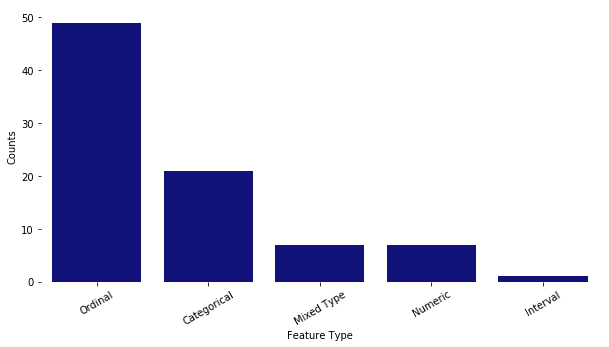

In [10]:
bar_chart(x= 'type', 
          data= feat_info,
          xticklabels= ['Ordinal', 'Categorical', 'Mixed Type', 'Numeric', 'Interval'],
          xlabel= 'Feature Type',
          ylabel= 'Counts')

### _Features Distribution by Information Level_

_When grouping features by information level, personal data are the highest registered features. Other information levels have a similar distribution._

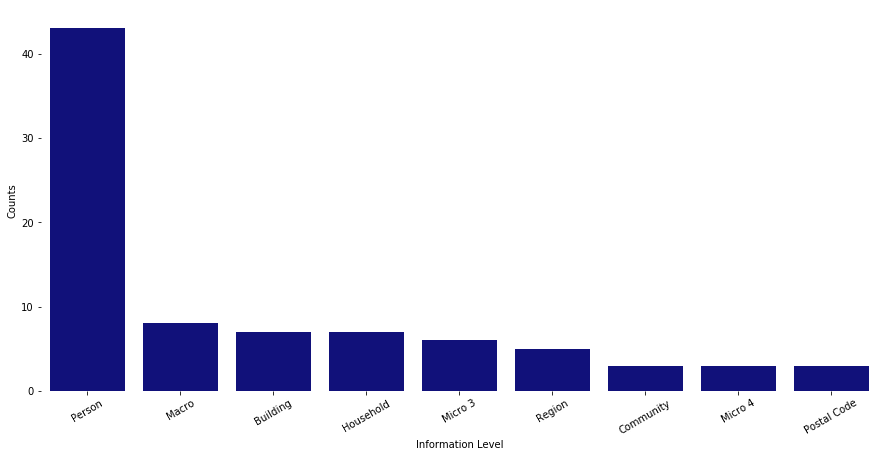

In [11]:
bar_chart(x= 'information_level', 
          data= feat_info,
          xticklabels= ['Person', 'Macro', 'Building', 'Household', 'Micro 3', 'Region', 'Community', 'Micro 4', 'Postal Code'],
          xlabel= 'Information Level',
          ylabel= 'Counts',
          figsize=(15,7))

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

#parsing values from string to list
feat_copy = feat_info.copy()
feat_copy['missing_or_unknown']=feat_copy['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',')

#creating a dictionary with key, value pairs where each key is the column name 
#and the value is a list for codes of missing values
missing_or_unknown =feat_copy.set_index('attribute')['missing_or_unknown'].to_dict()

#replacing missing values with NaN
azdias_nan = azdias.copy() #copy to prevent any chnage in original data
for key,val in missing_or_unknown.items():
    for v in val:
        if v not in ['X', 'XX', '']: # if the value is not a string then convert it to int
            v = int(v)
        azdias_nan = azdias_nan.replace(to_replace={key:v}, value=np.nan)
azdias_nan # azdias data with nulls

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


_We can recognize that there is a change in the number of non-null features after parsing and updating the azdias dataset._

In [13]:
azdias_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

*Check if the azdias_nan has no codes from the missing dictionary.*

In [14]:
# check if codes for missing values were replaced
assert azdias_nan.isin(missing_or_unknown).sum(axis=0).sum() == 0

*Let's save the azdias_nan data to csv file in case the kernal crashed.*

In [15]:
#save the azdias_nan data to csv in case the kernal crashed.
# azdias_nan.to_csv(path_or_buf='azdias_nan.csv')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the dataset.
a = round(100 * azdias_nan.isnull().sum()/len(azdias_nan),2)
# percentage of missing data in each column sorted DESC order
pd.DataFrame(a.sort_values(ascending=False), columns=['%_of_nan'])

,%_of_nan
TITEL_KZ,99.76
AGER_TYP,76.96
KK_KUNDENTYP,65.60
KBA05_BAUMAX,53.47
GEBURTSJAHR,44.02
ALTER_HH,34.81
REGIOTYP,17.74
KKK,17.74
W_KEIT_KIND_HH,16.61
KBA05_ANTG4,14.96


*Let's check for the distribution of missing values in our dataset. In particular, let's look at any column with missing values percentage bigger than 20%.*

*The highest columns are:*

| Tables        | % Missing Values         | Describtion                                                  |
| ------------- |:------------------------:| ------------------------------------------------------------:|
| TITEL_KZ      | 99.76%                   | Academic title flag                                          |
| AGER_TYP      | 76.96%                   | Best ager typology for each customer                         |
| KK_KUNDENTYP  | 65.60%                   | Consumer pattern over past 12 months                         |
| KBA05_BAUMAX  | 53.47%                   | Most common building type within the microcell for a customer|
| GEBURTSJAHR   | 44.02%                   | Year of birth                                                |
| ALTER_HH      | 34.81%                   | Birthdate of head of household                               |

*Such columns contain data that might not have an impact on the analysis results or the reliability of such data is challenging to be verified.*

In [17]:
pd.DataFrame(a[a>20].sort_values(ascending=False), columns=['%_of_nan'])# percentage of missing data in each column

,%_of_nan
TITEL_KZ,99.76
AGER_TYP,76.96
KK_KUNDENTYP,65.60
KBA05_BAUMAX,53.47
GEBURTSJAHR,44.02
ALTER_HH,34.81


*Let's look at the histogram of each feature in the entire dataset. It is tricky to evaluate the dataset by looking at this very dense distribution grid. However generally speaking* 

*However, generally speaking, most columns have a discrete distribution as most values cluster into specific bins. The following features, however, have a continuous distribution; ```ALTER_HH, GEBURTSJAHR, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, KBA13_ANZAHL_PKW```*

*It's a good idea to isolate the number of nulls in each feature, and subsequently, we can draw a distribution of the number of nulls perceived in the dataset given by each feature.*

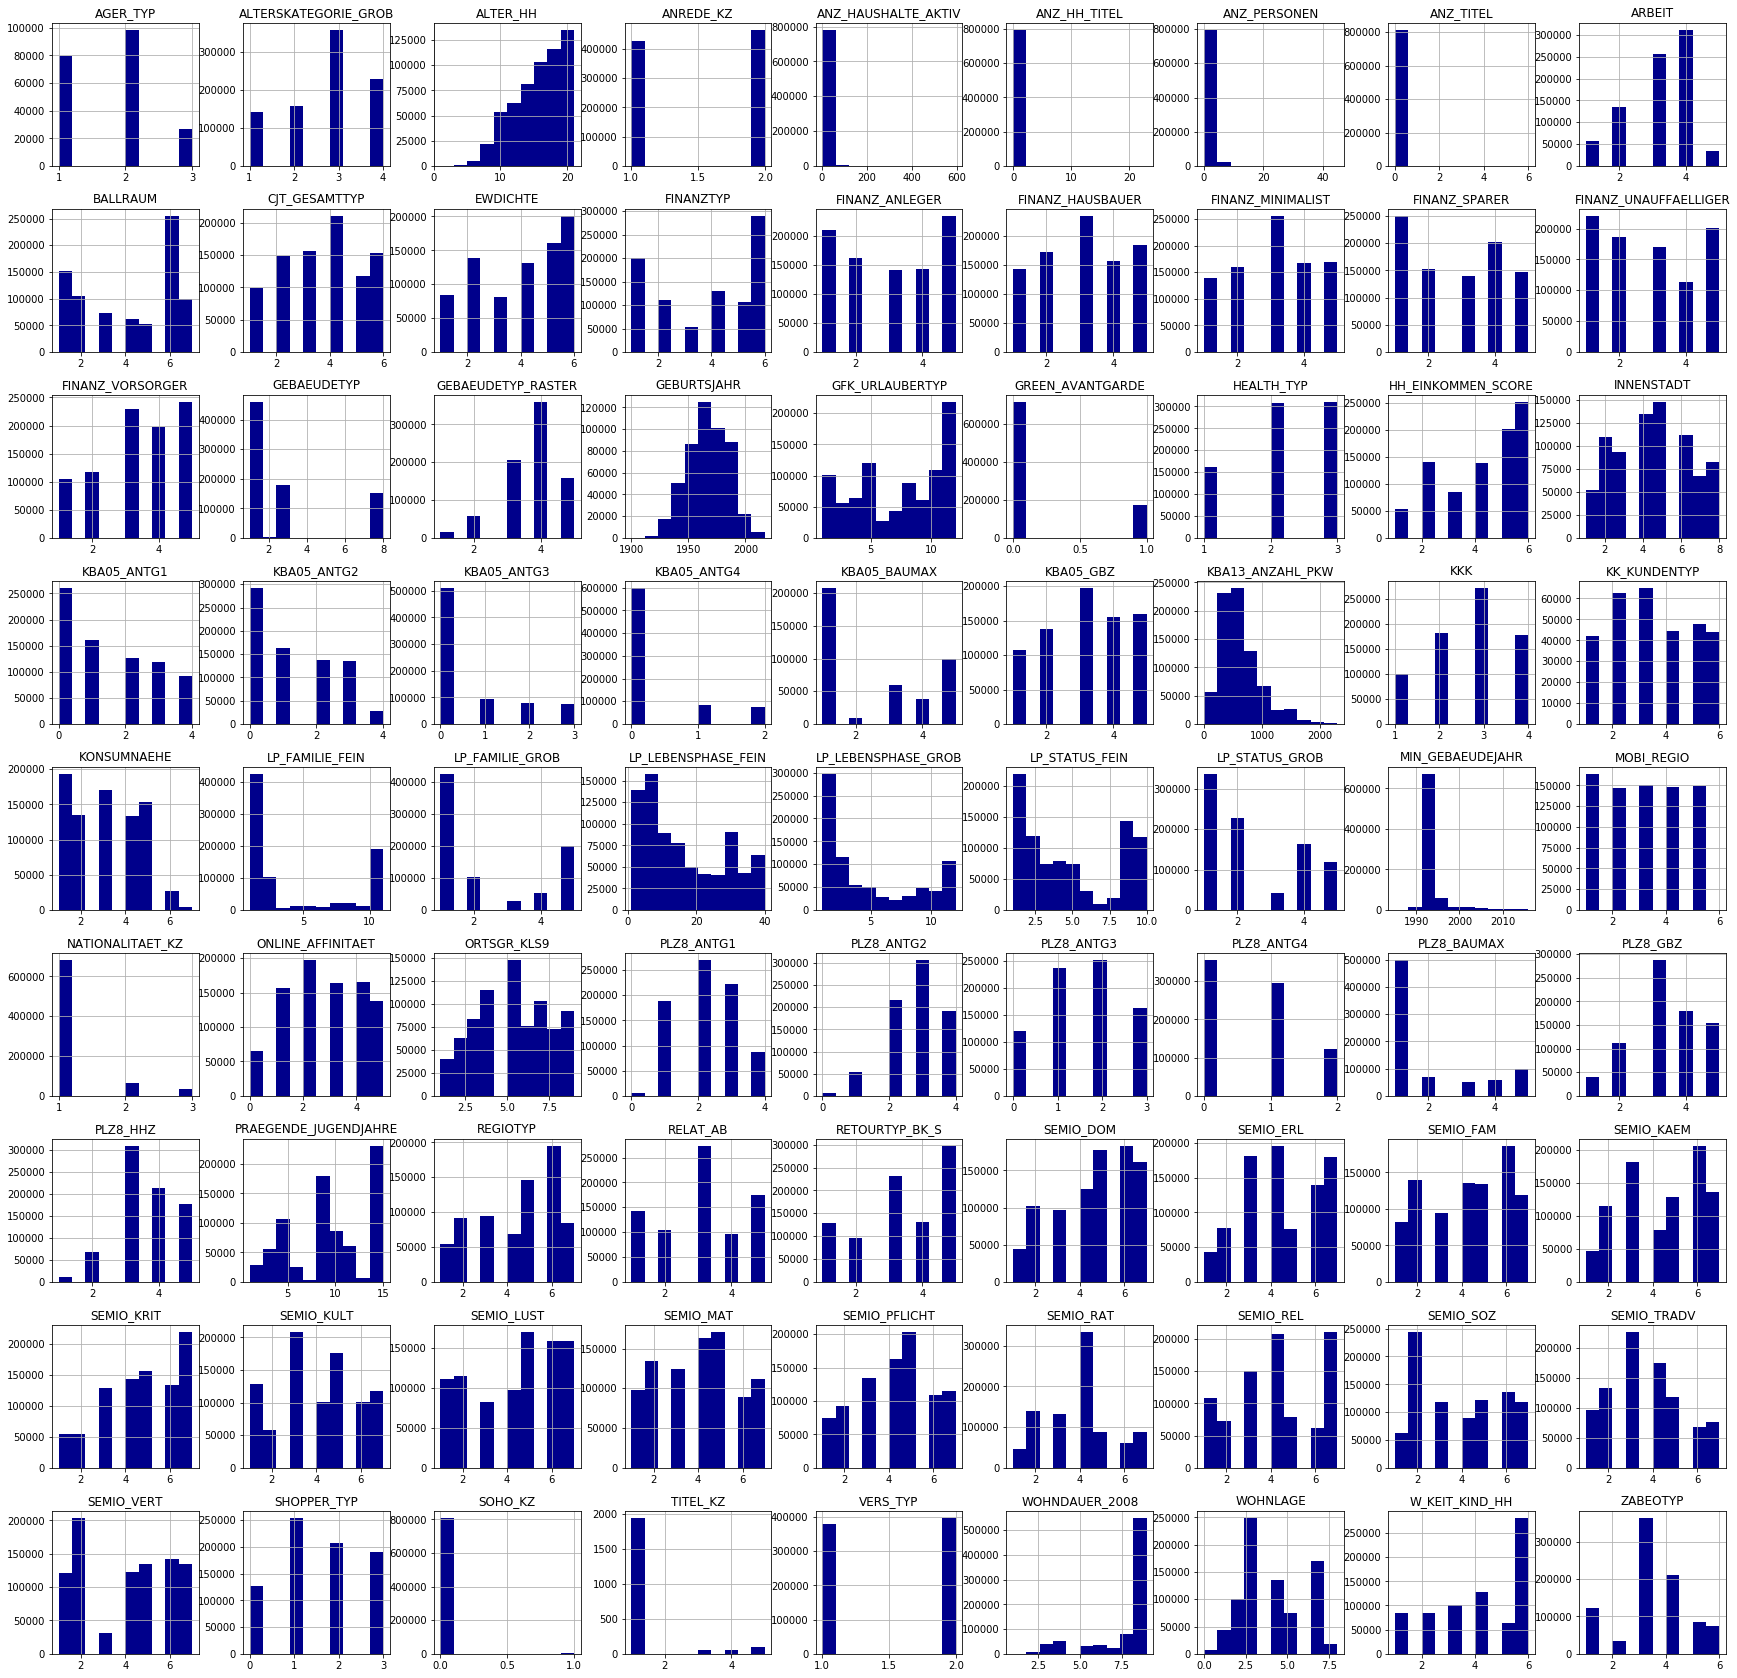

In [18]:
azdias_nan.hist(figsize=(30,30), color='darkblue');

*Let's examine the distibution of missing values in the dataset. The bulk of these features have missing values of less than 20%. Columns outside of this range should be removed from the dataset.*

In [19]:
def histogram(x, bins, xlabel='', ylabel='Frequency', title='', figure_size=(10,5), font_weight='bold', font_size=12):
    #creat figure layout
    plt.figure(figsize=figure_size)
    cur_axes = plt.gca()
    cur_axes.spines['right'].set_visible(False)
    cur_axes.spines['top'].set_visible(False)
    cur_axes.set_xlim([np.min(x), np.max(x)])

    font = {'weight': font_weight, 'size': font_size}

    #creating the histogram
    plt.hist(x=x, bins=bins, color='darkblue', edgecolor='black', linewidth=1.2) 
    plt.xlabel(xlabel, **font)
    plt.xticks(**font)
    plt.yticks(**font)
    plt.ylabel(ylabel, **font)
    plt.title(title, **font)
    plt.show()

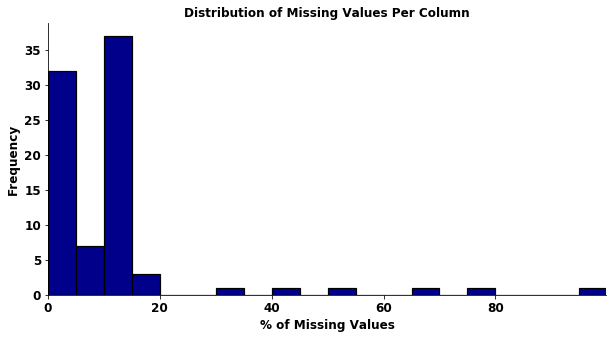

In [20]:
#percentage of missing data in each column
#formating the chart
'''
plt.figure(figsize=(10,5))
cur_axes = plt.gca()
cur_axes.spines['right'].set_visible(False)
cur_axes.spines['top'].set_visible(False)
font = {'weight': 'bold', 'size': 12}

#creating the histogram
plt.hist(a.sort_values(ascending=False), bins=list(range(0,105,5)), color='darkblue', edgecolor='black', linewidth=1.2) 
plt.xlabel('% of Missing Values', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.ylabel('Frequency', **font)
plt.title('Distribution of Missing Values Per Column', **font)
plt.show()
'''
histogram(x= a.sort_values(ascending=False), 
         bins= list(range(0,105,5)), 
         xlabel= '% of Missing Values',
         ylabel= 'Frequency',
         title= 'Distribution of Missing Values Per Column') 

*The columns to be removed are:*

- ```TITEL_KZ: 99.76%```
- ```AGER_TYP: 76.96%```
- ```KK_KUNDENTYP: 65.60%```
- ```KBA05_BAUMAX: 53.47%```
- ```GEBURTSJAHR: 44.02%```
- ```ALTER_HH: 34.81%```

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
to_drop = list(a[a>20].sort_values(ascending=False).index)
azdias_clean = azdias_nan.drop(axis=1, labels=to_drop)

#check if columns still exist
assert to_drop not in list(azdias_clean.columns)

In [22]:
azdias_clean.shape

(891221, 79)

***Now we have dataset with columns having % of missing values less than 20%.***

#### Discussion 1.1.2: Assess Missing Data in Each Column

*As mentioned, the bulk of these features have missing values of less than 20%. Columns outside of this range should be removed from the dataset. Therefore, the following columns were removed; ```(TITEL_KZ - 99.76%), (AGER_TYP: 76.96%), (KK_KUNDENTYP: 65.60%), (KBA05_BAUMAX: 53.47%), (GEBURTSJAHR: 44.02%) and (ALTER_HH: 34.81%).```*

Other columns have a missing value % less than 20% as demonstrated in the above analysis.

*Also, the excluded columns contain data that might not have an impact on the analysis results, or the reliability and verification of such data will be a challenging issue. It's a good idea to discuss the importance of such missing columns with the owners of the dataset and get their feedback on the exclusion reseasons. Also, we can discuss what can be done in the future to include more info on such features or exclude these features from the data collection process in the future.*

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?
nulls_per_row = azdias_clean.shape[1] - azdias_clean.apply(lambda x: x.count(), axis=1)

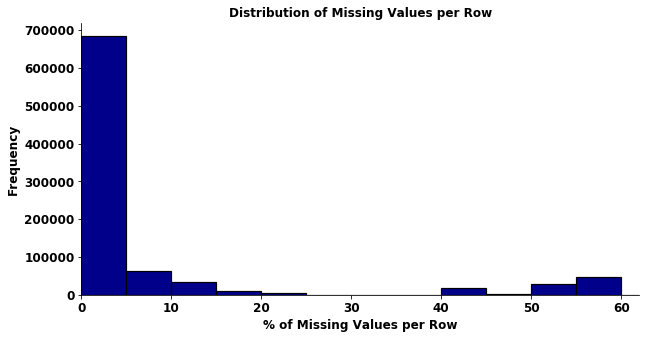

In [24]:
per_nulls_per_row = 100 * nulls_per_row/azdias_clean.shape[1]
per_nulls_per_row = pd.Series(per_nulls_per_row.sort_values(ascending=False))
'''
plt.figure(figsize=(10,5))
cur_axes = plt.gca()
cur_axes.spines['right'].set_visible(False)
cur_axes.spines['top'].set_visible(False)
font = {'weight': 'bold', 'size': 12}

#creating the histogram
plt.hist(per_nulls_per_row, bins=list(range(0,105,5)), color='darkblue', edgecolor='black', linewidth=1.2) 
plt.xlabel('% of Missing Values per Row', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.ylabel('Frequency', **font)
plt.title('Distribution of Missing Values per Row', **font)
plt.show()
'''

histogram(per_nulls_per_row, 
         bins=list(range(0,105,5)), 
         xlabel='% of Missing Values per Row',
         ylabel = 'Frequency',
         title= 'Distribution of Missing Values per Row')

In [25]:
# Determining the cutout threshold
threhold = []
for i in range(5, 40):
    threhold.append((i,len(per_nulls_per_row [per_nulls_per_row > i])))
threhold

[(5, 206719),
 (6, 194112),
 (7, 171597),
 (8, 157826),
 (9, 144112),
 (10, 144112),
 (11, 119520),
 (12, 116478),
 (13, 111068),
 (14, 109941),
 (15, 109941),
 (16, 109175),
 (17, 105920),
 (18, 103677),
 (19, 98934),
 (20, 98934),
 (21, 96429),
 (22, 95752),
 (23, 95324),
 (24, 95324),
 (25, 94144),
 (26, 93795),
 (27, 93645),
 (28, 93516),
 (29, 93516),
 (30, 93384),
 (31, 93315),
 (32, 93260),
 (33, 93201),
 (34, 93201),
 (35, 93177),
 (36, 93172),
 (37, 93160),
 (38, 93154),
 (39, 93154)]

By examining th above results from the table and the histogram figure, the threshold should be around 19%.

In [26]:
set_1 = list(per_nulls_per_row[per_nulls_per_row > 19].index)
set_2 = list(per_nulls_per_row[per_nulls_per_row <= 19].index)

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_clean_set_1 = azdias_clean.iloc[set_1] # rows > 19%
azdias_clean_set_2 = azdias_clean.iloc[set_2] # rows <= 19%

In [28]:
assert len(azdias_clean_set_1)+ len(azdias_clean_set_2) == len(azdias_clean)

Let's check the difference between distribution in columns with no or very few missing values in **azdias_clean_set_1** and **azdias_clean_set_2** as recommended in the instructions. We will do it for the five columns with the least number of missing values.

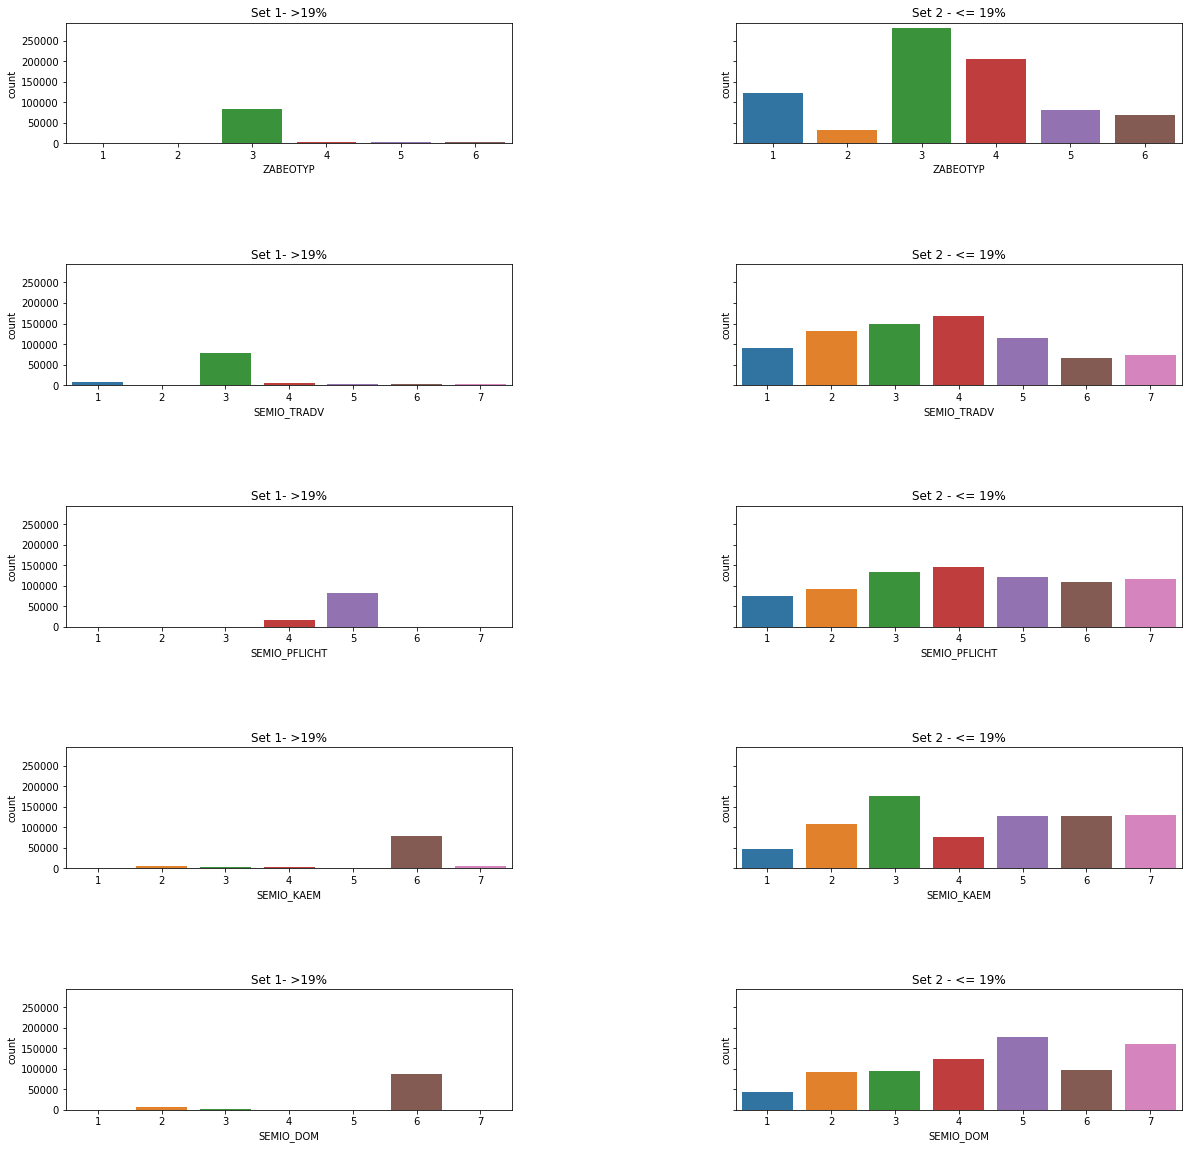

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_five_columns(col_names):
    fig, ax = plt.subplots(nrows=5, ncols=2, sharey=True)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)
    for i in range(5):
        sns.countplot(x=col_names[i], data=azdias_clean_set_1, ax=ax[i,0])
        ax[i,0].set_title('Set 1- >19%')
        sns.countplot(x=col_names[i], data=azdias_clean_set_2, ax =ax[i,1])
        ax[i,1].set_title('Set 2 - <= 19%')
        
plot_five_columns(list(a.sort_values(ascending=True)[0:5].index));

Let's repeat the same process for the next five columns. This is a sanity check.

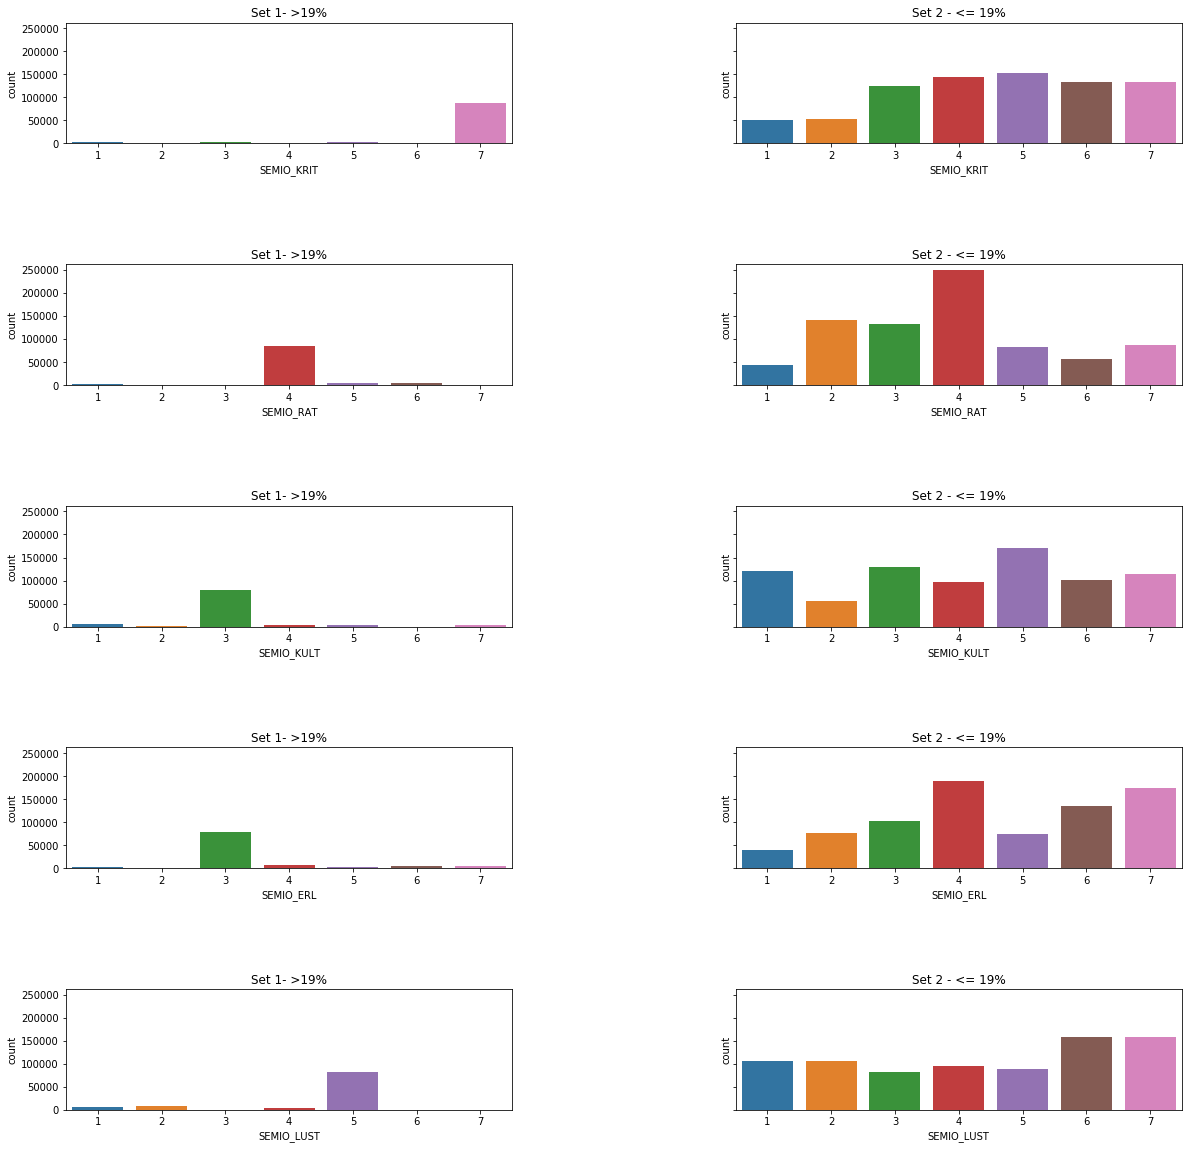

In [30]:
plot_five_columns(list(a.sort_values(ascending=True)[5:11].index))

#### Discussion 1.1.3: Assess Missing Data in Each Row

*When comparing between the two datasets (```azdias_clean_set_1``` - > 19%) (```azdias_clean_set_2``` - <=19%), the data with many missing values looks very different from the data with no or few missing values. We should make a note on those data as special. This observation was confirmed by performing the analysis steps on ten columns.*

***As requested, we should continue our analysis for now using just the subset of the data with few or no missing values ```azdias_clean_set_2```.***

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
pd.DataFrame(feat_info.groupby(by=['type'])['type'].count().reset_index(name='count')).sort_values(by='count', ascending=False)

,type,count
4,ordinal,49
0,categorical,21
2,mixed,7
3,numeric,7
1,interval,1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# get list of categorical columns
categorical = list(feat_info[feat_info['type'] == 'categorical']['attribute'])
categorical_clean = [cat for cat in categorical if cat not in to_drop] # removing columns droped in step 1.1.2
categorical_clean

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

*Let's look at the distribution of categorical features in the azdias dataset.*

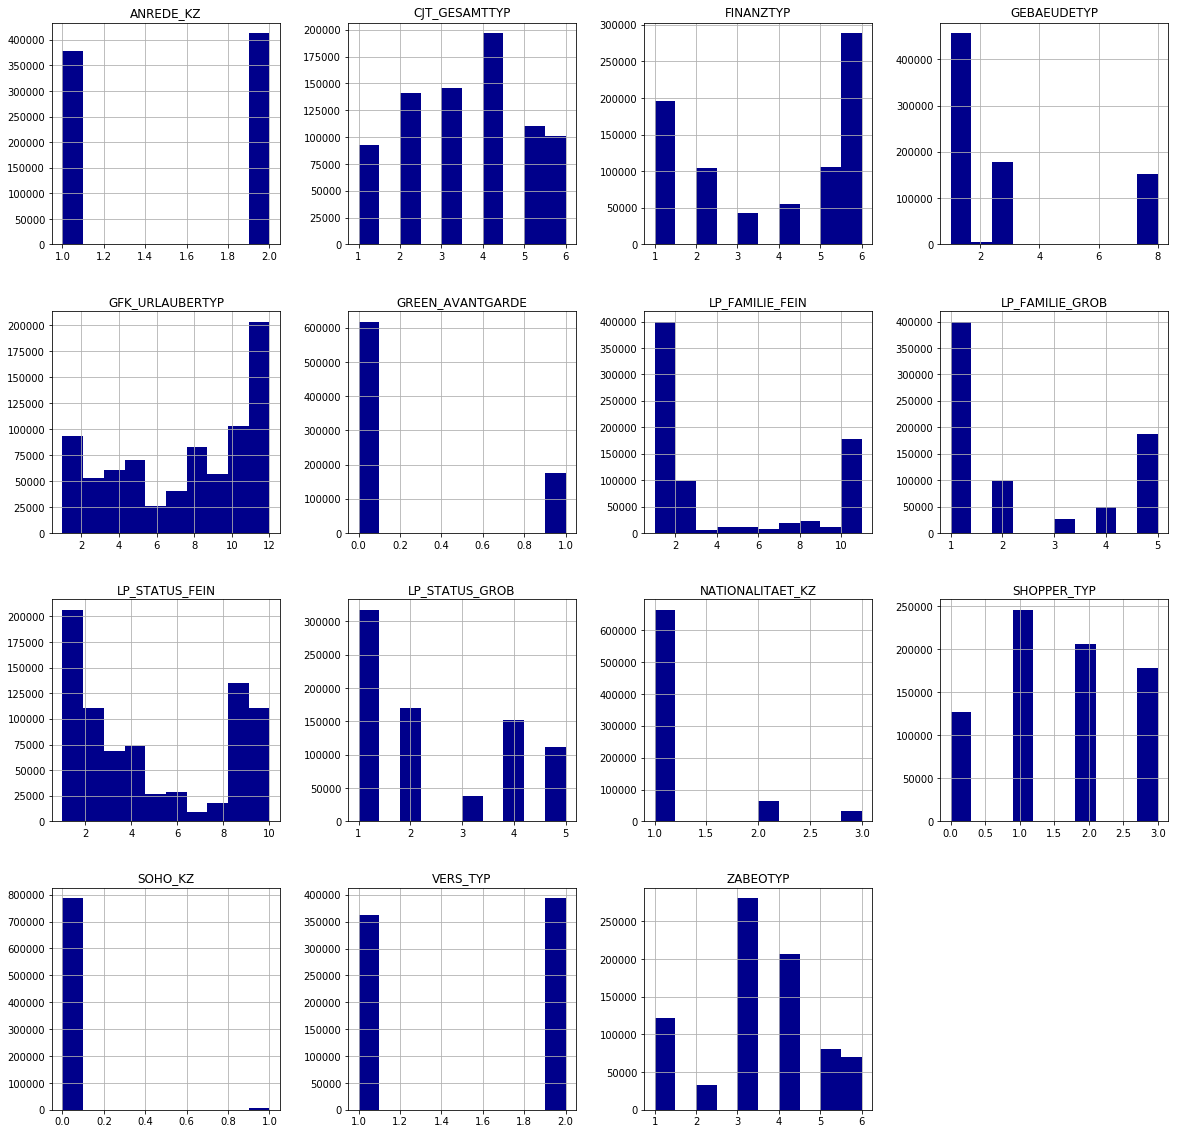

In [33]:
azdias_clean_set_2[categorical_clean].hist(figsize=(20,20), color='darkblue');

Let's check the data-type and unique values found for each categorical feature. 

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_info = []
for cat in categorical_clean:
    cat_info.append([cat,azdias_clean_set_2[cat].dtype, len(azdias_clean_set_2[cat].dropna().unique())])
cat_info = pd.DataFrame(cat_info, columns=['col_name', 'type', 'counts'])
cat_info

,col_name,type,counts
0,ANREDE_KZ,int64,2
1,CJT_GESAMTTYP,float64,6
2,FINANZTYP,int64,6
3,GFK_URLAUBERTYP,float64,12
4,GREEN_AVANTGARDE,int64,2
5,LP_FAMILIE_FEIN,float64,11
6,LP_FAMILIE_GROB,float64,5
7,LP_STATUS_FEIN,float64,10
8,LP_STATUS_GROB,float64,5
9,NATIONALITAET_KZ,float64,3


*Let's draw a count plot for the last three features with ```object``` data-type.*

**OST_WEST_KZ Count Plot**

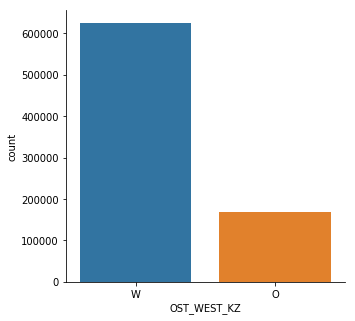

In [35]:
#function to draw a count plot for a column_name in a datset with specific figure height and width
def count_plot(col_name, dataset, fig_height=10, fig_width=20):
    fig, ax = plt.subplots()
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_width)
    sns.countplot(x=col_name, data=dataset, ax=ax, order=dataset[col_name].value_counts().index)
    sns.despine(right=True, top=True)

count_plot(col_name='OST_WEST_KZ', dataset=azdias_clean_set_2, fig_height=5, fig_width=5)

**CAMEO_DEUG_2015 Count Plot**

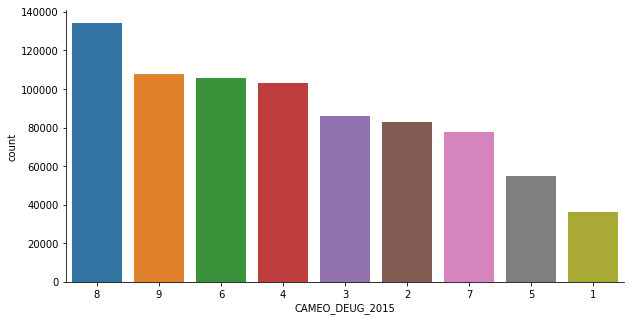

In [36]:
count_plot(col_name='CAMEO_DEUG_2015', dataset=azdias_clean_set_2, fig_height=5, fig_width=10)

**CAMEO_DEU_2015 Count Plot**

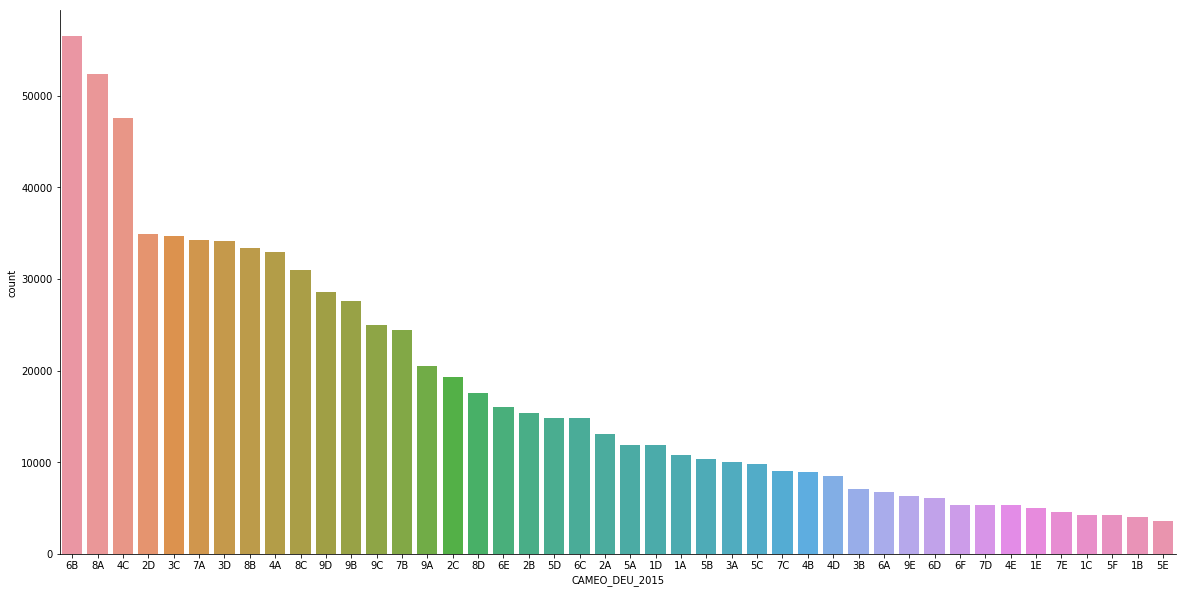

In [37]:
count_plot(col_name='CAMEO_DEU_2015', dataset=azdias_clean_set_2)

*By checking the above barcharts, countplots and the table summary for categorical features, these are the observations:*

*Binary features are:*
- ```ANREDE_KZ```
- ```GREEN_AVANTGARDE```
- ```SOHO_KZ```
- ```VERS_TYP```
- ```OST_WEST_KZ```

*Multi-multi-level features are:*  
- ```CJT_GESAMTTYP```
- ```FINANZTYP```
- ```GEBAEUDETYP```
- ```GFK_URLAUBERTYP```
- ```LP_FAMILIE_FEIN```
- ```LP_FAMILIE_GROB```
- ```LP_STATUS_FEIN```
- ```LP_STATUS_GROB```
- ```NATIONALITAET_KZ```
- ```SHOPPER_TYP```
- ```ZABEOTYP```
- ```CAMEO_DEUG_2015```
- ```CAMEO_DEU_2015```

*We will create a new dataframe called ```azdias_dummies``` which will have the categorical features only for now cleaned and engineered for further analysis.*

*It should be noted that I took the ```azdias_clean_set_2``` which has a few missing records and imputed the Nan records using the ```ffill``` method. My logic is that we have excluded ```98,937``` rows from ```891,221```  which is around 11% loss in our data. Given the size of our dataset, this is not a significant shrinkage in the dataset size. We can use the forward fill method as a simple and intuitive initial step for now and at later stages of our analysis, we can use other imputation techniques.  Also, imputing missing values now will significantly facilitate the data engineering process.* 

**_Rencode Categorical Variables_**

In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary_col = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
re_encoded_col = cat_info['col_name'].apply(lambda x: x not in binary_col)
re_encoded_col = list(cat_info['col_name'][re_encoded_col])
azdias_clean_set_2 = azdias_clean_set_2.fillna(method='ffill')
azdias_set_2_copy = azdias_clean_set_2.copy()

for col_name in re_encoded_col:
    azdias_set_2_copy[col_name] = pd.Categorical(azdias_set_2_copy[col_name])
azdias_dummies = pd.get_dummies(azdias_set_2_copy[re_encoded_col])

In [39]:
assert azdias_dummies.shape[0] == azdias_clean_set_2.shape[0] # checking that the rencoding didn't change the shape of our data

In [40]:
#dataset contain categorical features only
azdias_dummies = pd.concat([azdias_clean_set_2[binary_col], azdias_dummies], axis=1)

*The ```azdias_dummies``` dataset has categorical features only. Let's have a look at the dataset structure.*

In [41]:
azdias_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792287 entries, 784380 to 445610
Columns: 133 entries, ANREDE_KZ to CAMEO_DEU_2015_9E
dtypes: float64(2), int64(2), object(1), uint8(128)
memory usage: 153.0+ MB


*Let's reencode the binary features to make sure that all columns have consistent data-type size and format.*

In [42]:
# Re-encode binary features
azdias_dummies['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias_dummies['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias_dummies['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
azdias_dummies['SOHO_KZ'] = azdias_dummies['SOHO_KZ'].astype(int, errors='ignore')
azdias_dummies['VERS_TYP'] = azdias_dummies['VERS_TYP'].astype(int, errors='ignore') 

*Let's have another look at the rencoded dataset.*

In [43]:
azdias_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792287 entries, 784380 to 445610
Columns: 133 entries, ANREDE_KZ to CAMEO_DEU_2015_9E
dtypes: int64(5), uint8(128)
memory usage: 153.0 MB


In [44]:
azdias_dummies.head() #dataset contain categorical features only

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
784380,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
155149,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
691708,1,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
172425,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
722762,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*This is a sanity check that we have the right number of categorical features after the rencoding process.*

In [45]:
# check that we have the correct number of dummy features
assert azdias_dummies.shape[1] == cat_info['counts'].sum() - 5 

#### Discussion 1.2.1: Re-Encode Categorical Features

*We have explored the categorical features of our dataset using barcharts, countplots and summary tables. We grouped the data into binary and multi-level features. We used the pandas ```get_dummies``` to create a new dataset called ```azdias_dummies```. The new dataset includes dummy encoding for multi-level features. The binary features were rencoded as [0,1] to ensure that our dummy coding is consistent across all fearures. The next step will be to look at the mixed-type features and then combine all valid features into a clean and well structured dataset for clustering analysis.*

*No categroical features were excluded from the analysis.*

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# dictionary to map the the coded values in each column as requested
dict_PRAEGENDE = {1: [40, 1], 2: [40, 0], 3: [50,0], 4: [50,1], 5: [60, 0], 6: [60, 1], 7: [60, 1], 8: [70,0], 9: [70,1],
                  10: [80,0], 11: [80, 1], 12: [80, 0], 13: [80, 1], 14: [90, 0], 15: [90, 1]}

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_dummies['decade'] = azdias_clean_set_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: dict_PRAEGENDE[int(x)][0])
azdias_dummies['movement'] = azdias_clean_set_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: dict_PRAEGENDE[int(x)][1])
azdias_dummies.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement
784380,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,70,0
155149,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,70,0
691708,1,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,90,1
172425,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,90,0
722762,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,50,0


***Count Plots for Decade and Movement Features***

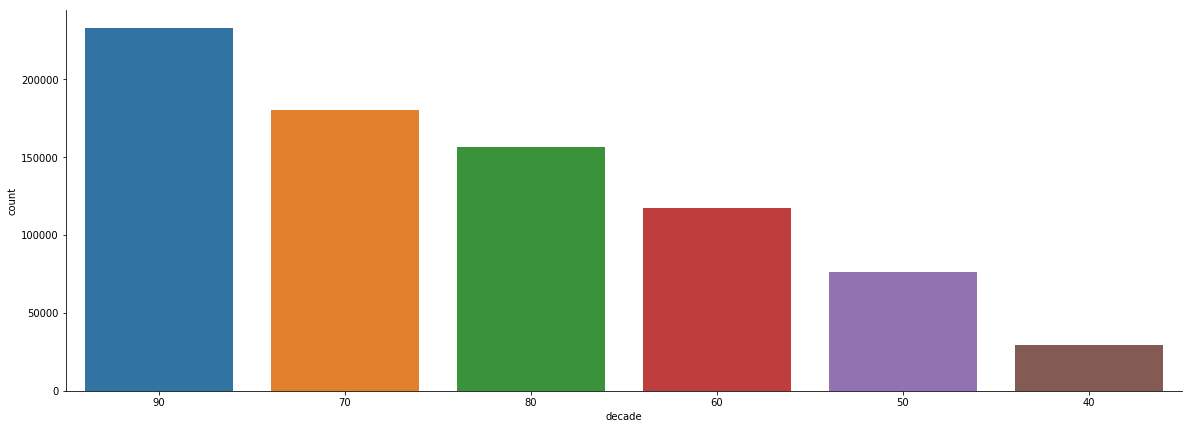

In [48]:
count_plot(col_name='decade', dataset=azdias_dummies, fig_height=7)

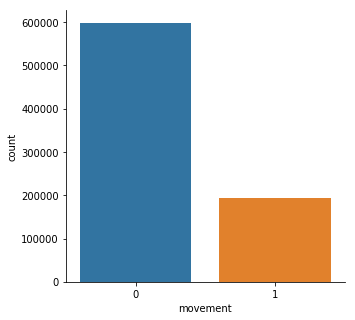

In [49]:
count_plot(col_name='movement', dataset=azdias_dummies, fig_height=5, fig_width=5)

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dummies['wealth'] = azdias_clean_set_2['CAMEO_INTL_2015'].str[0].astype(int)
azdias_dummies['life_stage'] = azdias_clean_set_2['CAMEO_INTL_2015'].str[1].astype(int)
azdias_dummies.head() # data contain two mixed-type features

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage
784380,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,70,0,5,4
155149,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,70,0,2,3
691708,1,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,90,1,4,3
172425,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,90,0,2,5
722762,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,50,0,2,3


***Count Plots for Wealth and Life_stage Features***

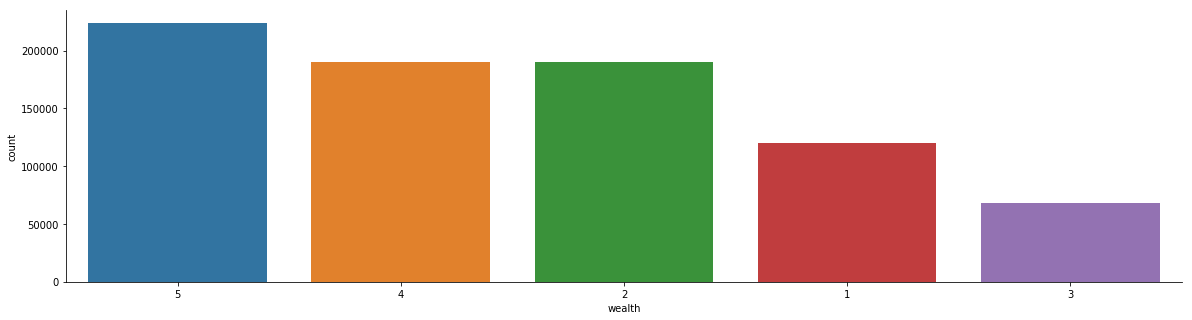

In [51]:
count_plot(col_name='wealth', dataset=azdias_dummies, fig_height=5)

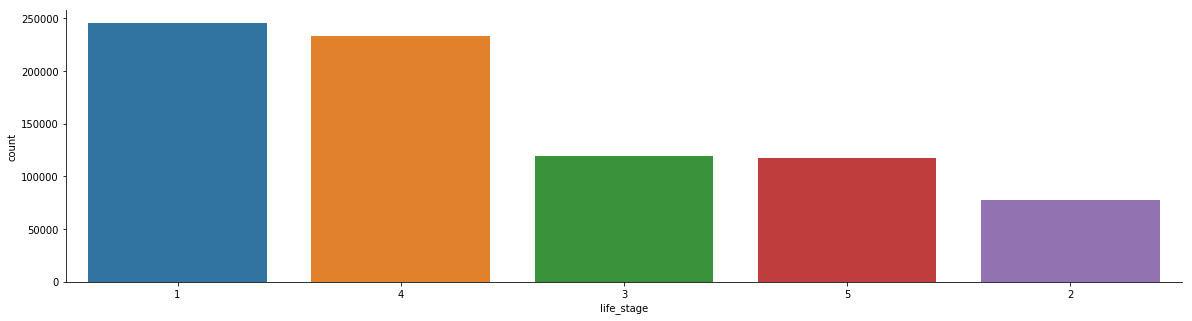

In [52]:
count_plot(col_name='life_stage', dataset=azdias_dummies, fig_height=5)

In [53]:
azdias.shape, azdias_dummies.shape

((891221, 85), (792287, 137))

#### Discussion 1.2.2: Engineer Mixed-Type Features

*```PRAEGENDE_JUGENDJAHRE``` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). We created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.*

*```CAMEO_INTL_2015``` combines information on two axes: wealth and life stage. we divided the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables as requested.*

*These two mixed-type features were added to the ```azdias_dummies``` dataset as requested. The dataset now has all binary and multilevel features plus two mixed-type features re encoded into 4 new columns; wealth, life_stage, decade and movement. Other mixed level features were left as an option. For now, the other five features were excluded from the analysis. This assumption should be revisted before deploying this model into production.*

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
ordinal = list(feat_info[feat_info['type'] == 'ordinal']['attribute'])
interval = list(feat_info[feat_info['type'] == 'interval']['attribute'])
numeric = list(feat_info[feat_info['type'] == 'numeric']['attribute'])

all_columns = ordinal + interval + numeric
all_columns = [col for col in all_columns if col not in to_drop]

azdias_dummies = pd.concat([azdias_dummies, azdias_clean_set_2[all_columns]], axis=1)

*Now we have a dataset that includes all ordinal, numeric and interval features plus the categorical features that were preprocessed in previous steps. We have 192 columns and 792,287 rows.*

In [55]:
azdias_dummies.shape

(792287, 192)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [197]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #copy to prevent any chnage in original data
    df_nan = df.copy() 
    for key,val in missing_or_unknown.items():
        for v in val:
            if v not in ['X', 'XX', '']: # if the value is not a string then convert it to int
                v = int(v)
            df_nan = df_nan.replace(to_replace={key:v}, value=np.nan) # azdias data with nulls
    
    # remove selected columns and rows, ...
    df_clean = df_nan.drop(axis=1, labels=to_drop)
    
    # remove rows
    nulls_per_row = df_clean.shape[1] - df_clean.apply(lambda x: x.count(), axis=1)
    per_nulls_per_row = 100 * nulls_per_row/df_clean.shape[1] # percentage of nulls per row
    per_nulls_per_row = pd.Series(per_nulls_per_row.sort_values(ascending=False))
    set_1 = list(per_nulls_per_row[per_nulls_per_row <= 19].index)
    df_clean_set_1 = df_clean.iloc[set_1] # rows <= 19%
    
    # select, re-encode, and engineer column values.
    df_clean_set_1 = df_clean_set_1.fillna(method='ffill')
    
    # categorical features only
    for col_name in re_encoded_col:
        df_clean_set_1[col_name] = pd.Categorical(df_clean_set_1[col_name])
    
    # get dummy coding for multi-level categorical features
    df_dummies = pd.get_dummies(df_clean_set_1[re_encoded_col])
    # add binary features to the other categorical features 
    df_dummies = pd.concat([df_clean_set_1[binary_col], df_dummies], axis=1)
    
    # rencode binary features with [0,1] to ensure consistency in our dummy coding 
    df_dummies['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df_dummies['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df_dummies['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    df_dummies['SOHO_KZ'] = df_dummies['SOHO_KZ'].astype(int, errors='ignore')
    df_dummies['VERS_TYP'] = df_dummies['VERS_TYP'].astype(int, errors='ignore') 
    df_dummies['GEBAEUDETYP_5.0'] = 0
    
    # create the mixed type features
    df_dummies['decade'] = df_clean_set_1['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: dict_PRAEGENDE[int(x)][0])
    df_dummies['movement'] = df_clean_set_1['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: dict_PRAEGENDE[int(x)][1])
    df_dummies['wealth'] = df_clean_set_1['CAMEO_INTL_2015'].str[0].astype(int)
    df_dummies['life_stage'] = df_clean_set_1['CAMEO_INTL_2015'].str[1].astype(int)
    
    # Return the cleaned dataframe.
    return pd.concat([df_dummies, df_clean_set_1[all_columns]], axis=1)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

*By looking at the histogram grid below, one can conclude that we have features that are skewed to the left or the right. To deal with such skewness, we can use the median for numeric features as an estimate to replace missing values. The mean is sensitive to outliers and this may disrupt the results of our analysis.*

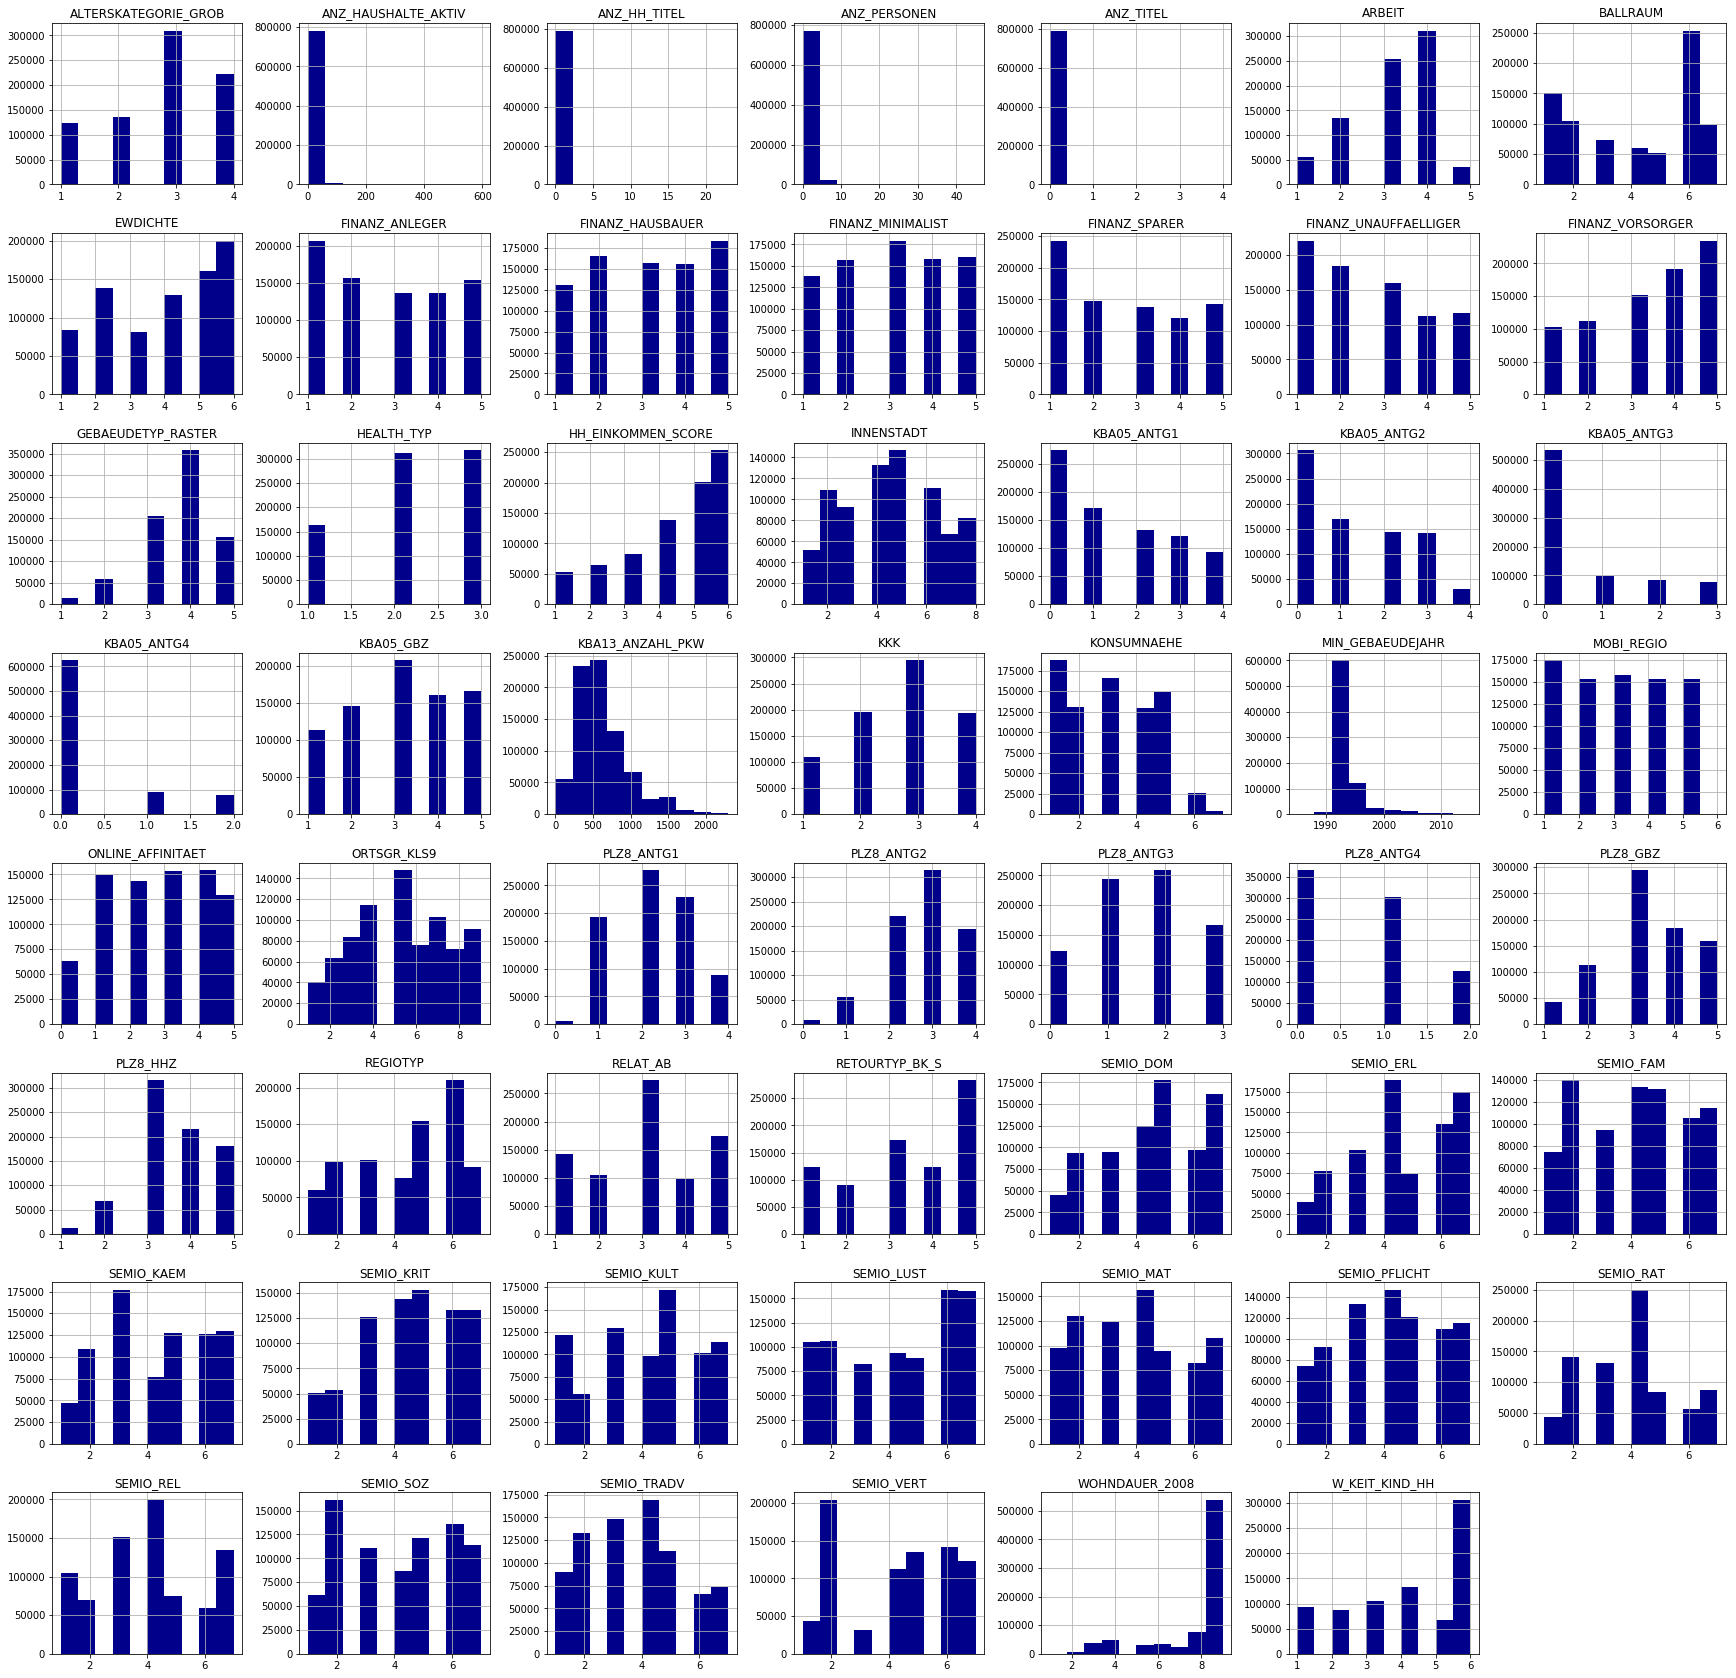

In [57]:
azdias_dummies[all_columns].hist(figsize=(30,30), color='darkblue'); # looks at numerical, interval and ordinal columns

*We will use the Imputer module of sklearn to impute missing values and then use StandardScaler to make sure all columns have a mean of 0 and std of 1 as requested.*

In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imputer =  Imputer(strategy='median')
imputed_features = imputer.fit_transform(azdias_dummies[all_columns])

In [59]:
azdias_dummies[all_columns] = imputed_features

In [60]:
assert azdias_dummies.isnull().sum().sum() == 0 # check that there is no nulls

In [61]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_dummies)

In [62]:
# casting the azdias_scaled data as a dataframe
azdias_scaled = pd.DataFrame(azdias_scaled, columns=list(azdias_dummies.columns.values))
azdias_scaled.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
0,-1.043729,-0.531050,-0.092093,-1.035275,0.517873,-0.364757,-0.465787,-0.476383,1.735671,-0.405836,...,-0.346356,-0.168627,-0.995506,-0.052905,-0.631531,-0.060609,0.926264,-0.125793,0.608126,0.188099
1,-1.043729,-0.531050,-0.092093,-1.035275,0.517873,-0.364757,-0.465787,-0.476383,1.735671,-0.405836,...,-0.346356,0.832683,0.741355,1.417250,-0.631531,-0.060609,-0.469632,-0.125793,5.910783,-0.214418
2,0.958103,1.883063,-0.092093,0.965927,0.517873,-0.364757,-0.465787,-0.476383,1.735671,-0.405836,...,-0.346356,-1.169936,-1.429722,-0.052905,2.824655,-0.060609,-0.469632,-0.125793,5.910783,1.566059
3,-1.043729,-0.531050,-0.092093,-1.035275,0.517873,-0.364757,-0.465787,-0.476383,-0.576146,-0.405836,...,-0.346356,-1.169936,-1.429722,-0.052905,0.232515,-0.060609,-0.469632,-0.125793,5.579367,-0.243799
4,-1.043729,-0.531050,-0.092093,-1.035275,0.517873,2.741551,-0.465787,-0.476383,-0.576146,-0.405836,...,-0.346356,-1.169936,-0.561291,-0.787982,0.232515,-0.060609,-0.469632,-0.125793,6.242199,0.878548


*Check that all our features have a mean of 0 and std of 1.*

In [63]:
azdias_scaled.describe()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,...,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05,7.922870e+05
mean,3.569363e-17,-3.529903e-17,5.497537e-17,1.517428e-17,4.695775e-17,-4.549144e-18,2.419634e-17,-9.434598e-17,7.336028e-17,-2.353269e-17,...,1.583793e-16,1.900193e-16,1.752037e-16,1.316898e-16,-5.151362e-17,2.860872e-17,7.512702e-17,4.234359e-17,1.554592e-14,4.405204e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.043729e+00,-5.310496e-01,-9.209319e-02,-1.035275e+00,-1.930974e+00,-3.647570e-01,-4.657873e-01,-4.763827e-01,-5.761459e-01,-4.058364e-01,...,-2.144764e+00,-2.171245e+00,-1.863937e+00,-1.523059e+00,-1.495577e+00,-6.060906e-02,-4.696320e-01,-1.257933e-01,-2.706035e+00,-1.821549e+00
25%,-1.043729e+00,-5.310496e-01,-9.209319e-02,-1.035275e+00,5.178734e-01,-3.647570e-01,-4.657873e-01,-4.763827e-01,-5.761459e-01,-4.058364e-01,...,-3.463564e-01,-1.686267e-01,-5.612908e-01,-7.879820e-01,-6.315309e-01,-6.060906e-02,-4.061822e-01,-1.257933e-01,-3.861226e-01,-6.933257e-01
50%,9.581032e-01,-5.310496e-01,-9.209319e-02,9.659273e-01,5.178734e-01,-3.647570e-01,-4.657873e-01,-4.763827e-01,-5.761459e-01,-4.058364e-01,...,-3.463564e-01,-1.686267e-01,-1.270754e-01,-5.290455e-02,-6.315309e-01,-6.060906e-02,-2.792826e-01,-1.257933e-01,-3.861226e-01,-2.085422e-01
75%,9.581032e-01,-5.310496e-01,-9.209319e-02,9.659273e-01,5.178734e-01,-3.647570e-01,-4.657873e-01,-4.763827e-01,-5.761459e-01,-4.058364e-01,...,5.528476e-01,8.326827e-01,7.413553e-01,6.821729e-01,2.325155e-01,-6.060906e-02,1.014162e-01,-1.257933e-01,-5.470652e-02,4.642786e-01
max,9.581032e-01,1.883063e+00,1.085857e+01,9.659273e-01,5.178734e-01,2.741551e+00,2.146903e+00,2.099153e+00,1.735671e+00,2.464047e+00,...,1.452051e+00,1.833992e+00,1.609786e+00,1.417250e+00,3.738651e+01,5.830435e+01,3.721955e+01,7.072205e+01,7.236448e+00,4.936040e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

*By looking at the histogram grid for the clean ```azdias dataset```,  one can conclude that most features are skewed to the right or the left. Using the median as an estimate for nulls is a good starting point.*

*The ```Imputer``` class of the sklearn library was used to estimate missing values.* 

*The dataset was then scaled using the ```StandardScaler``` class to make sure that all features have a mean of zero and std of 1. This data is then ready to be analyzed by ```PCA```.*

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [64]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    font = {'weight': 'bold', 'fontsize': 12}
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(0, num_components, 10):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", **font)
        if i:
            ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i]+0.2, cumvals[i]+0.02), va="bottom", ha="center", **font)
    
    ax.annotate(r"%s%%" % ((str(cumvals.max()*100)[:4])), (ind[num_components-1]+0.2, cumvals[num_components-1]+0.02), va="bottom", ha="center", **font)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component", **font)
    ax.set_ylabel("Variance Explained (%)", **font)
    cur_axes = plt.gca()
    cur_axes.spines['right'].set_visible(False)
    cur_axes.spines['top'].set_visible(False)
    plt.title('Explained Variance Per Principal Component', **font)
    plt.xticks(**font)
    plt.yticks(**font)

In [65]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
pca = pca.fit(azdias_scaled)
azdias_pca = pca.transform(azdias_scaled)

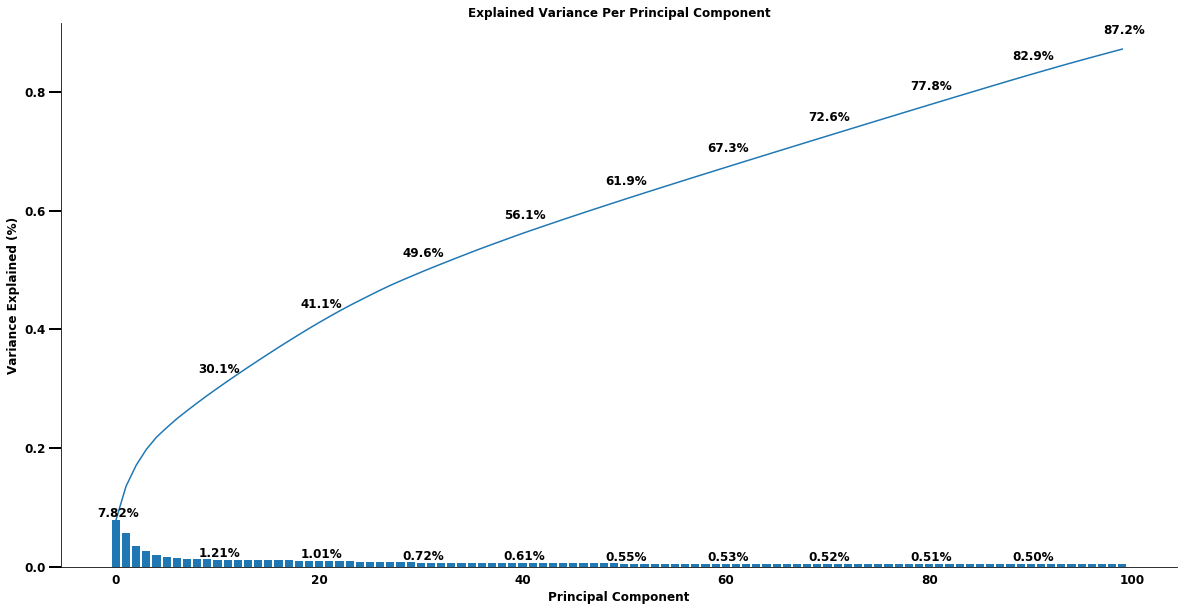

In [66]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [67]:
print('Maximum Explained Variance: {}'.format(round(pca.explained_variance_ratio_.sum()*100, 2)))

Maximum Explained Variance: 87.26


*As shown in the above scree plot, the maximum explained variance ratio using 100 components is 87.2%. If we used 90 components, the ratio will be 82.9%. I would say retaining a number of components that will result in explaining 80% of the variance is sufficient for the clustering part of the project. Therefore, I will go with a number of components equal to 95.*

In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=95, random_state=42)
pca = pca.fit(azdias_scaled)
azdias_pca = pca.transform(azdias_scaled)

In [69]:
print('Maximum Explained Variance: {}'.format(round(pca.explained_variance_ratio_.sum()*100, 2)))

Maximum Explained Variance: 84.78


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

*At first the PCA was utilized on ```100``` components. The amount of variance explained by these ```100``` components is ```87.2%```. The scree plot shows the amount of variance explained by each component and the cumulative variance explained as well. Retaining a number of components that will result in explaining ```80%``` of the variance in the azdias dataset is sufficient as a starting point to perform the clustering analysis. Therefore, ```95``` components are maintained. The amount of variance explained by the 95 components is ```84.78%```.*

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

*A function called ```pca_results``` was defined. It takes three inputs; a ```dataframe```, ```pca object``` and a ```dimension```. It returns a bar chart for the top 10 weights and another for the last 10 weights. It also returns the top 10 and last 10 weights as a dataframe.*

In [93]:
# This function will return a pca bar chart for the top 10 and last 10 weights for a selected dimension
# It will also return a dataframe for the top 10 weights and another for the least 10 weights.
def pca_results(full_dataset, pca, dimension=1):
    '''
    Create a DataFrame of the Top 10 and Least 10 PCA weights in a given dimension
    Includes dimension feature weights and explained variance
    Visualizes the Top 10 and Least 10 PCA weights
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Getting the top 10 weights and last 10 weights
    ev_df = pd.concat([variance_ratios, components], axis = 1)
    
    top_10 = ev_df.iloc[dimension-1,:].sort_values(ascending=False)[:10].to_frame().reset_index()
    last_10 = ev_df.iloc[dimension-1,:].sort_values().to_frame()[:10].reset_index()
    
    fig, ax =plt.subplots(2,1)
    font = {'weight': 'bold', 'fontsize': 15}
    fig.set_figheight(20)
    fig.set_figwidth(35)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    y = 'Dimension ' + str(dimension)
    for i in range(2):
        if i ==0:
                ax[i].set_title(top_10.columns[1] + ' - Top 10 Features', **font)
                sns.barplot(x='index', y=y, data=top_10, ax=ax[i])
                ax[i].set_xticklabels(labels=top_10['index'], **font)
                ax[i].set_yticklabels(labels=round(top_10[y],2), **font)
        else:
                ax[i].set_title(top_10.columns[1] + ' - Last 10 Features', **font)
                sns.barplot(x='index', y=y, data=last_10, ax=ax[i])
                ax[i].set_xticklabels(labels=last_10['index'], **font)
                ax[i].set_yticklabels(labels=round(last_10[y],2), **font)

        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)    
        ax[i].set_xlabel("", **font)
        ax[i].set_ylabel("Feature Weight", **font)

    # Return two DataFrames one for the top 10 and another for last 10 weights
    return top_10, last_10

### First Dimension

**Top 10 and Last 10 Weights**

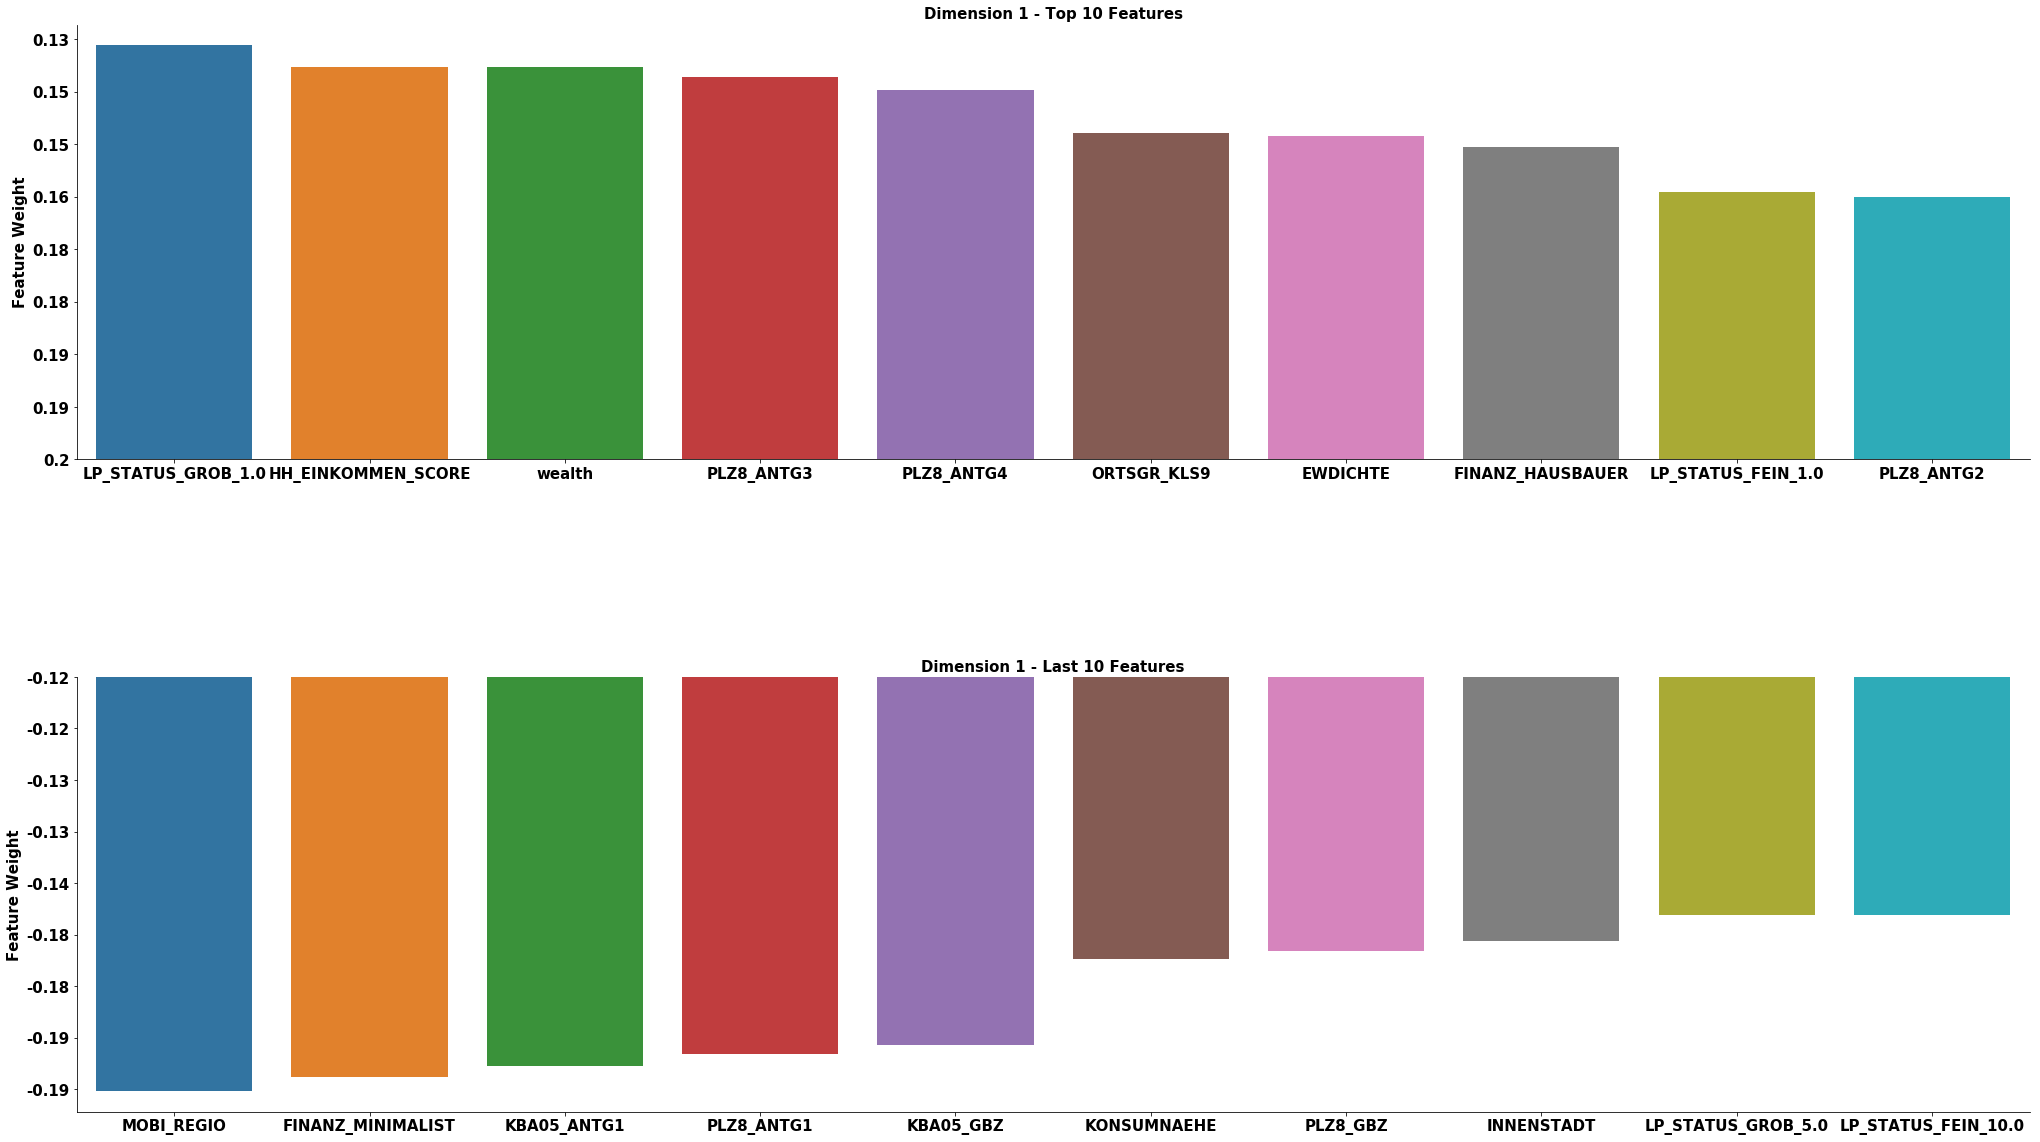

In [94]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
dim_1_top_10, dim_1_last_10 = pca_results(azdias_dummies, pca, dimension=1)

*In the top 10 weights, ```LP_STATUS_GROB_1.0``` (```Personal feature```) is a person with a social status, income level, that is considered low. This is the most critical feature in explaining the variance in dimension 1. Next to ```LP_STATUS_GROB_1``` is ```HH_EINKOMMEN_SCORE``` which reflects the estimated household net income. ```wealth``` which is a ```RR4 micro-cell feature``` has a similar weight to ```HH_EINKOMMEN_SCORE```. On the other hand, ```PLZ8_ANTG3``` reflects the number of 6-10 family houses in the ```PLZ8 region``` and this is ```macro-cell```.*

*These observations suggest that a closer look should be paid to customers with high income and large family size. Are such customers a good target for receiving online promotions? This needs to be confirmed by the KMEAN clustering.*

*This pattern is positivly propotional with dimension 1.*

In [72]:
dim_1_top_10

,index,Dimension 1
0,LP_STATUS_GROB_1.0,0.1970
1,HH_EINKOMMEN_SCORE,0.1867
2,wealth,0.1866
3,PLZ8_ANTG3,0.1818
4,PLZ8_ANTG4,0.1759
5,ORTSGR_KLS9,0.1552
6,EWDICHTE,0.1541
7,FINANZ_HAUSBAUER,0.1488
8,LP_STATUS_FEIN_1.0,0.1270
9,PLZ8_ANTG2,0.1250


*In the last 10 weights, ```MOBI_REGIO``` (```RR1 region feature```) which reflects the movement patterns is the most negative feature in dimension 1. This basically may suggest paying a closer look at the the movement pattern of a customer. If a customer has a high movement pattern, does it mean that he or she will not be interested in recieving online promotions?*

*Next to ```MOBI_REGIO``` is ```FINANZ_MINIMALIST``` which reflects a person with very low financial interest. Also, there is ```KBA05_ANTG1``` which reflects the number of 1-2 family houses.if a customer has a hight movement pattern and small family size, will this customer be less likely interested in receiving promotions or emails about future offers?*

*Features in this group are more related to the regional or micro level. It also suggests nice observations between the family size, movement and income. This pattern is also negativly propotional with dimension 1.*

In [73]:
dim_1_last_10

,index,Dimension 1
0,MOBI_REGIO,-0.2008
1,FINANZ_MINIMALIST,-0.1940
2,KBA05_ANTG1,-0.1887
3,PLZ8_ANTG1,-0.1826
4,KBA05_GBZ,-0.1785
5,KONSUMNAEHE,-0.1370
6,PLZ8_GBZ,-0.1330
7,INNENSTADT,-0.1280
8,LP_STATUS_GROB_5.0,-0.1152
9,LP_STATUS_FEIN_10.0,-0.1152


### Second Dimension

**Top 10 and Last 10 Weights**

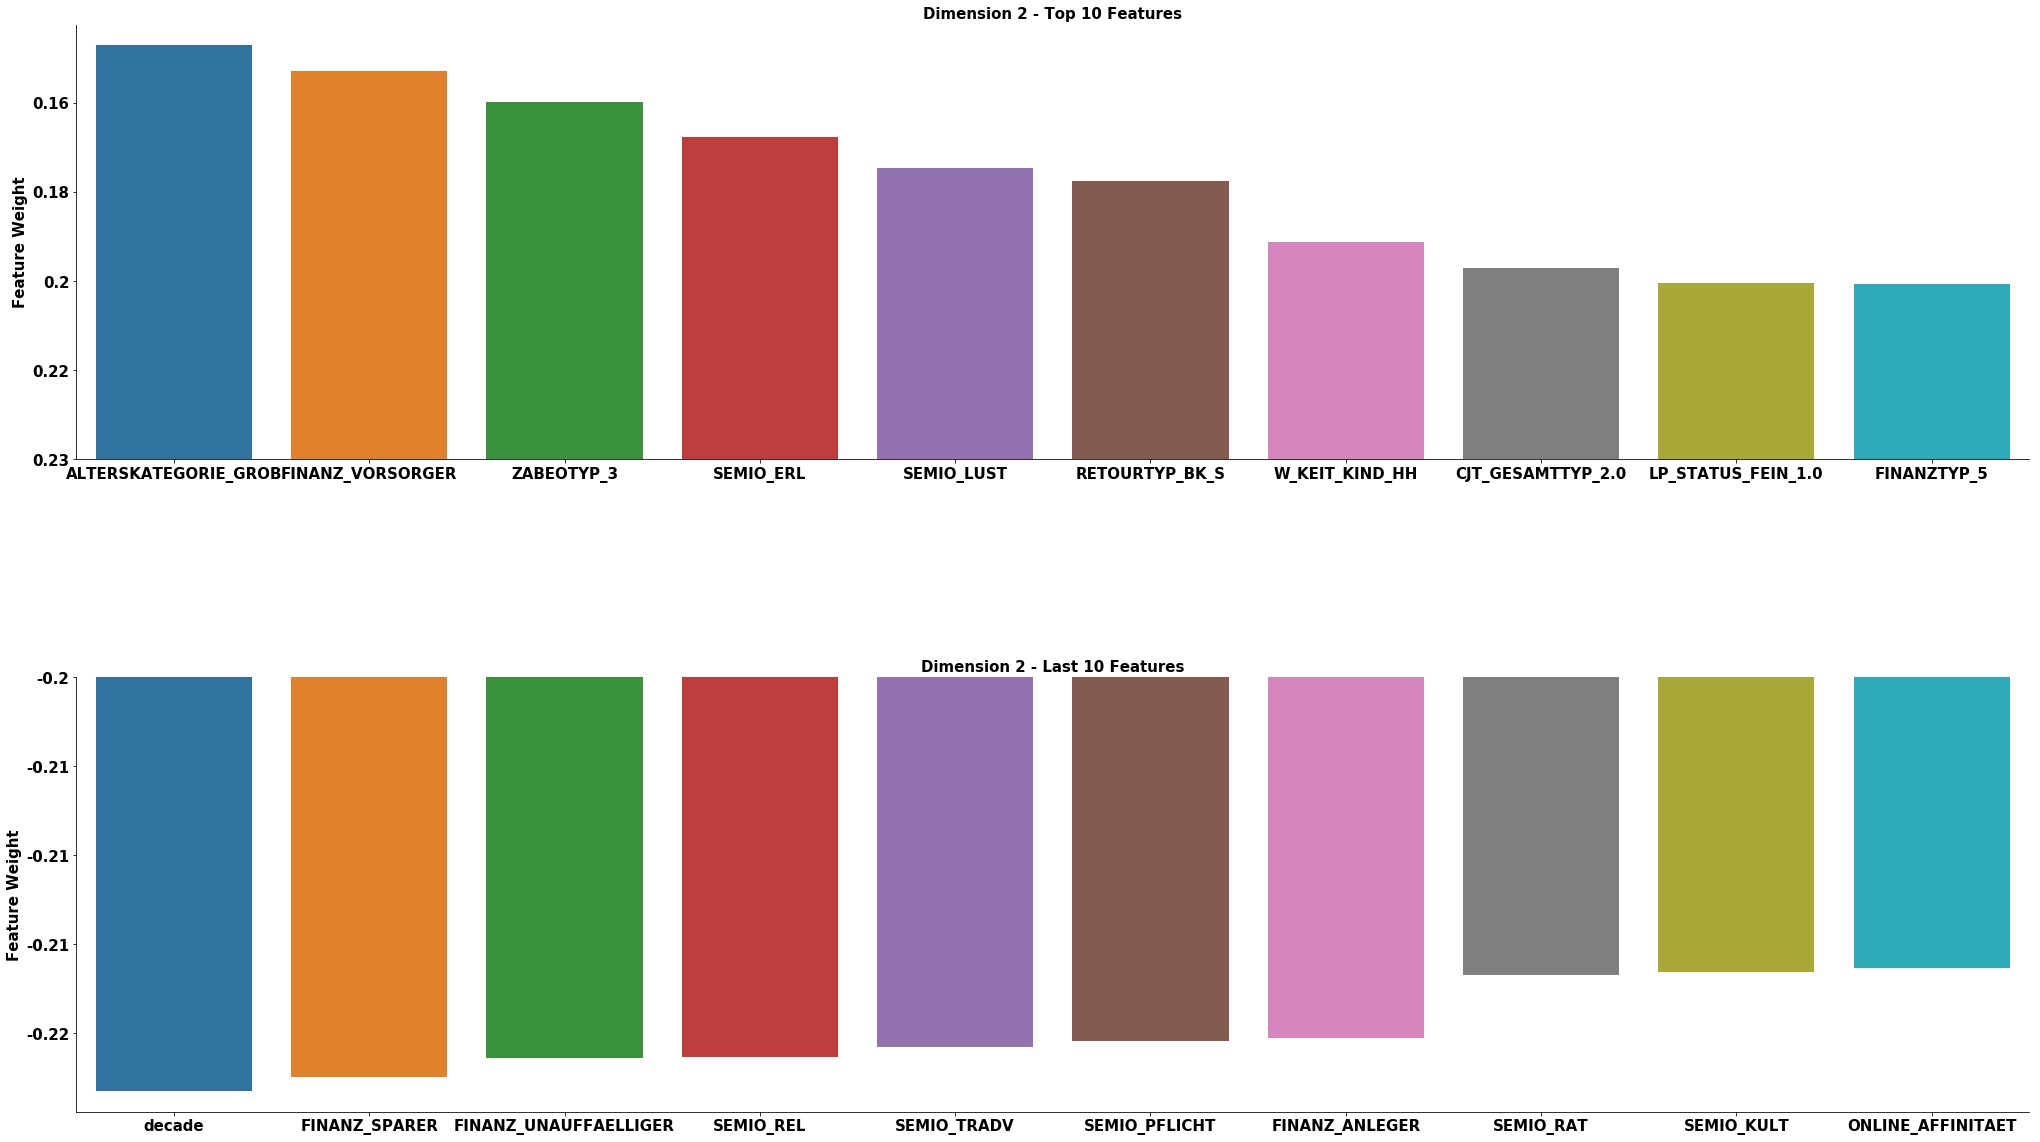

In [95]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

dim_2_top_10, dim_2_last_10 = pca_results(azdias_dummies, pca, dimension=2)

*The top three critical features in dimention 2 are; ```ALTERSKATEGORIE_GROB```, ```FINANZ_VORSORGER```, ```ZABEOTYP_3```. ```ALTERSKATEGORIE_GROB``` is the estimated age range for a person.  ```FINANZ_VORSORGER``` is a person who likes to be prepared for his or her purchases based on the provided dictionary file. ```ZABEOTYP_3``` reflects an energy consumption typology is fair supplied.*

*This group of features shows a pattern between the person's age group, and being prepared for his or her purchases financialy and the energy consmption in such region where a customer lives. This pattern is positivly propotional with dimension 2.*

In [75]:
dim_2_top_10

,index,Dimension 2
0,ALTERSKATEGORIE_GROB,0.2321
1,FINANZ_VORSORGER,0.2177
2,ZABEOTYP_3,0.2006
3,SEMIO_ERL,0.1807
4,SEMIO_LUST,0.1635
5,RETOURTYP_BK_S,0.1561
6,W_KEIT_KIND_HH,0.1220
7,CJT_GESAMTTYP_2.0,0.1075
8,LP_STATUS_FEIN_1.0,0.0991
9,FINANZTYP_5,0.0981


*In the last ten factors, The top three critical features in dimension 2 are; ```decade```, ```FINANZ_SPARER```, ```FINANZ_UNAUFFAELLIGER```. ```decade``` is the decade where this person grow up.  FINANZ_SPARER is a person who likes to save money file. FINANZ_UNAUFFAELLIGER is a person who doesn't want attention.*

*This group of features shows a pattern between the decade where a person grow up, his or her saving attitude and if he or she like to attract attention or not. This pattern is negativly propotional with dimension 2.*

In [76]:
dim_2_last_10

,index,Dimension 2
0,decade,-0.2325
1,FINANZ_SPARER,-0.2247
2,FINANZ_UNAUFFAELLIGER,-0.2141
3,SEMIO_REL,-0.2135
4,SEMIO_TRADV,-0.2080
5,SEMIO_PFLICHT,-0.2041
6,FINANZ_ANLEGER,-0.2026
7,SEMIO_RAT,-0.1671
8,SEMIO_KULT,-0.1655
9,ONLINE_AFFINITAET,-0.1633


### Third Dimension

**Top 10 and Last 10 Weights**

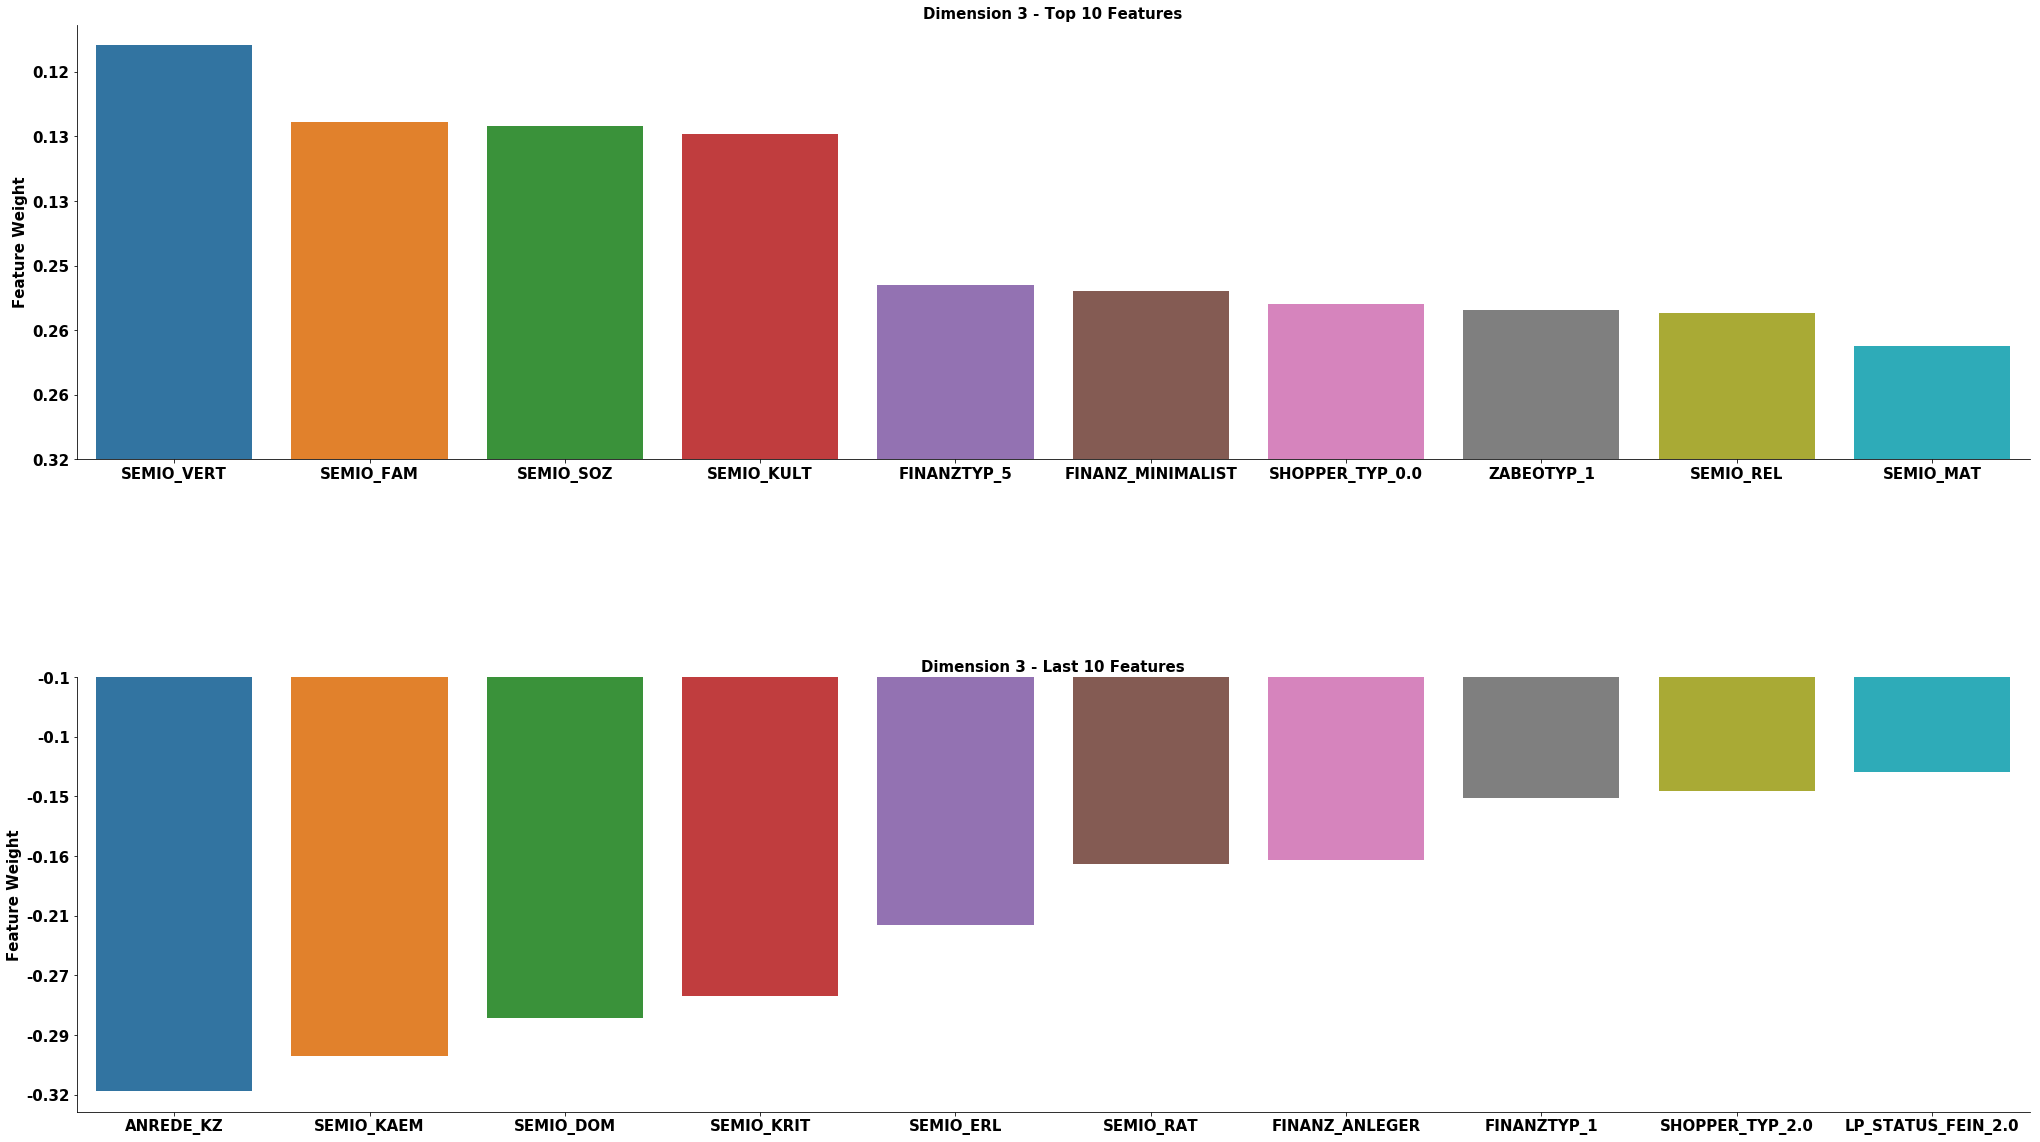

In [96]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

dim_3_top_10, dim_3_last_10 = pca_results(azdias_dummies, pca, dimension=3)

*The top four critical features with a very close weight distirbution in dimention 3 are; ```SEMIO_VERT```, ```SEMIO_FAM```, ```SEMIO_SOZ``` and ```SEMIO_KULT```. ```SEMIO_VERT``` is a person who can be decribed as dreamful. ```SEMIO_FAM``` is a family minded person and ```SEMIO_SOZ``` is a socially minded person.```SEMIO_KULT``` is a cultural minded person.*


*In this group of features, the personality of a person is major factor in explaining the variance in this dimension. It's also positivly propotional with this third dimension* 

In [79]:
dim_3_top_10

,index,Dimension 3
0,SEMIO_VERT,0.3204
1,SEMIO_FAM,0.2612
2,SEMIO_SOZ,0.2577
3,SEMIO_KULT,0.2521
4,FINANZTYP_5,0.1347
5,FINANZ_MINIMALIST,0.1302
6,SHOPPER_TYP_0.0,0.1205
7,ZABEOTYP_1,0.1157
8,SEMIO_REL,0.1132
9,SEMIO_MAT,0.0879


*The last four critical features with a very close weight distirbution in dimention 3 are; ```ANREDE_KZ```, ```SEMIO_KAEM```, ```SEMIO_DOM```, ```SEMIO_KRIT``` and ```SEMIO_ERL```. ```ANREDE_KZ``` is the gender type of a person. ```SEMIO_KAEM``` is a combative minded person and ```SEMIO_DOM``` is a dominant minded person.```SEMIO_ERL``` is an event-oriented person.*


*In this group of features, the personality of a person is also critical in explaining the variance in this dimension but in the other direction. These factors are negativly propotional with this Third dimension. This also means that a person who is not very social or family orient are unlikley to be part of dimention 3.*

In [80]:
dim_3_last_10

,index,Dimension 3
0,ANREDE_KZ,-0.3469
1,SEMIO_KAEM,-0.3171
2,SEMIO_DOM,-0.2857
3,SEMIO_KRIT,-0.2672
4,SEMIO_ERL,-0.2074
5,SEMIO_RAT,-0.1564
6,FINANZ_ANLEGER,-0.1534
7,FINANZTYP_1,-0.1018
8,SHOPPER_TYP_2.0,-0.0959
9,LP_STATUS_FEIN_2.0,-0.0800


### Discussion 2.3: Interpret Principal Components

#### Dimension 1

- *In the top 10 weights, ```LP_STATUS_GROB_1.0``` (```Personal feature```) is a person with a social status, income level, that is considered low. This is the most critical feature in explaining the variance in dimension 1. Next to ```LP_STATUS_GROB_1``` is ```HH_EINKOMMEN_SCORE``` which reflects the estimated household net income. ```wealth``` which is a ```RR4 micro-cell feature``` has a similar weight to ```HH_EINKOMMEN_SCORE```. On the other hand, ```PLZ8_ANTG3``` reflects the number of 6-10 family houses in the ```PLZ8 region``` and this is ```macro-cell```.*

    - *These observations suggest that a closer look should be paid to customers with high income and large family size. Are such customers a good target for receiving online promotions? This needs to be confirmed by the KMEAN clustering.*
    
    - *This pattern is positivly propotional with dimension 1.*


- *In the last 10 weights, ```MOBI_REGIO``` (```RR1 region feature```) which reflects the movement patterns is the most negative feature in dimension 1. This basically may suggest paying a closer look at the the movement pattern of a customer. If a customer has a high movement pattern, does it mean that he or she will not be interested in recieving online promotions?*

    - *Next to ```MOBI_REGIO``` is ```FINANZ_MINIMALIST``` which reflects a person with very low financial interest. Also, there is ```KBA05_ANTG1``` which reflects the number of 1-2 family houses.if a customer has a hight movement pattern and small family size, will this customer be less likely interested in receiving promotions or emails about future offers?*

    - *Features in this last group are more related to the regional or micro level. It also suggests nice observations between the family size, movement and income. This pattern is also negativly propotional with dimension 1.*

#### Dimension 2

- *The top three critical features in dimention 2 are; ```ALTERSKATEGORIE_GROB```, ```FINANZ_VORSORGER```, ```ZABEOTYP_3```. ```ALTERSKATEGORIE_GROB``` is the estimated age range for a person.  ```FINANZ_VORSORGER``` is a person who likes to be prepared for his or her purchases based on the provided dictionary file. ```ZABEOTYP_3``` reflects an energy consumption typology is fair supplied.*

    - *This top group of features shows a pattern between the person's age group, and being prepared for his or her purchases financialy and the energy consmption in such region where a customer lives. This pattern is positivly propotional with dimension 2.*

- *In the last ten factors, The top three critical features in dimension 2 are; ```decade```, ```FINANZ_SPARER```, ```FINANZ_UNAUFFAELLIGER```. ```decade``` is the decade where this person grow up.  FINANZ_SPARER is a person who likes to save money file. FINANZ_UNAUFFAELLIGER is a person who doesn't want attention.*

    - *This last group of features shows a pattern between the decade where a person grow up, his or her saving attitude and if he or she like to attract attention or not. This pattern is negativly propotional with dimension 2.*

#### Dimension 3

- *The top four critical features with a very close weight distirbution in dimention 3 are; ```SEMIO_VERT```, ```SEMIO_FAM```, ```SEMIO_SOZ``` and ```SEMIO_KULT```. ```SEMIO_VERT``` is a person who can be decribed as dreamful. ```SEMIO_FAM``` is a family minded person and ```SEMIO_SOZ``` is a socially minded person.```SEMIO_KULT``` is a cultural minded person.*

    - *In this top group of features, the personality of a person is major factor in explaining the variance in this dimension. It's also positivly propotional with this third dimension* 

- *The last four critical features with a very close weight distirbution in dimention 3 are; ```ANREDE_KZ```, ```SEMIO_KAEM```, ```SEMIO_DOM```, ```SEMIO_KRIT``` and ```SEMIO_ERL```. ```ANREDE_KZ``` is the gender type of a person. ```SEMIO_KAEM``` is a combative minded person and ```SEMIO_DOM``` is a dominant minded person.```SEMIO_ERL``` is an event-oriented person.*

    - *In this last group of features, the personality of a person is also critical in explaining the variance in this dimension but in the other direction. These factors are negativly propotional with this Third dimension. This also means that a person who is not very social or family orient are unlikley to be part of dimention 3.*

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [98]:
from sklearn.cluster import KMeans

In [106]:
# Over a number of different cluster counts...
kmeans = []
score = []
for k in range (1,35,5):
    # run k-means clustering on the data and...
    kmean = KMeans(n_clusters=k, random_state=42)
    k_model = kmean.fit(azdias_pca)
    
    # compute the score and append the model.
    score.append(kmean.score(azdias_pca))
    kmeans.append(k_model)

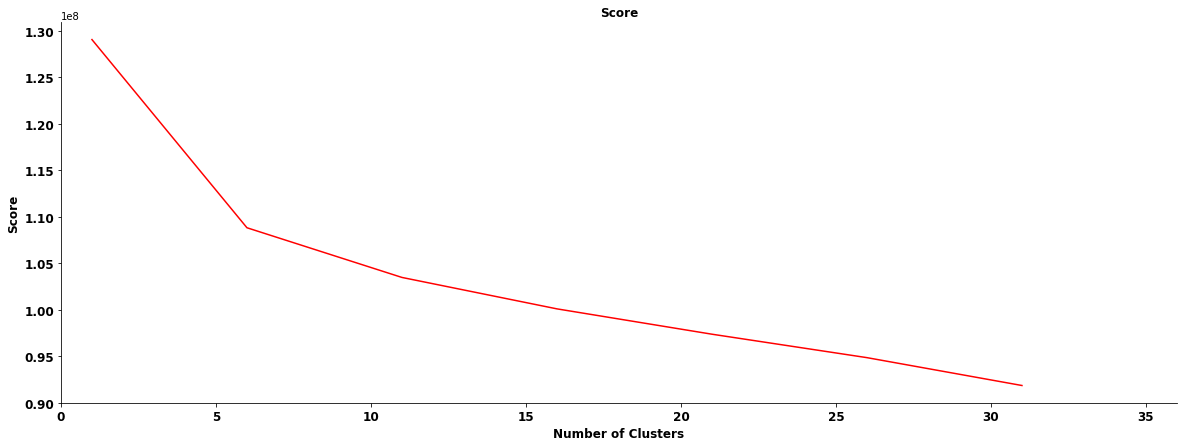

In [131]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
font = {'weight': 'bold', 'fontsize': 12}
plt.plot(list(range(1,36,5)), abs(np.array(score)), color = 'red')
plt.xlabel('Number of Clusters', **font)
plt.ylabel('Score', **font)
ax = plt.gca()
ax.figure.set_figheight(7)
ax.figure.set_figwidth(20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Score', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.xlim([0, 36]);

*By investigating the above figure, a good estimate for K will be 25. Each additional cluster does provides a smaller net benefit but this gain in the score is decreasing 40% at K=1 to 3% at culster 25. Therefore, Any K between (10-25) is a good  estimate for the number of clusters. I will go with 25 since it's the high-end of the boundary with the best score.*

In [133]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean = KMeans(n_clusters=25, random_state=42)
k_model = kmean.fit(azdias_pca)

In [134]:
full_azdias_clusters = k_model.labels_ 

### Discussion 3.1: Apply Clustering to General Population

*By investigating the above figure, a good estimate for K will be 25. Each additional cluster does provides a smaller net benefit but this gain in the score is decreasing from 40% at K=1 to 3% at culster 25. Therefore, Any K between (10-25) is a good estimate for the number of clusters. I will go with 25 since it's the high-end of the boundary with the best score.*

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [198]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [199]:
customers_clean = clean_data(customers)

In [207]:
assert customers_clean.shape[1] == azdias_dummies.shape[1]

In [211]:
customers_imputed_features = imputer.transform(X=customers_clean[all_columns])
customers_clean[all_columns] = customers_imputed_features
customers_scaled = scaler.transform(customers_clean)
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_clean.columns.values))

In [213]:
customers_pca = pca.transform(customers_scaled)
customers_labels = k_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [333]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

azdias_scaled['labels'] = list(full_azdias_clusters)
customers_scaled['labels'] = list(customers_labels)

azdias_dummies['labels'] = list(full_azdias_clusters)
customers_clean['labels'] = list(customers_labels)

### The Customer Dataset VS The General Dataset

In the customer dataset, we can observe by looking at the count plot below that clusters 14, 2, 23, 17 are the top four clusters. In the general dataset, 2,14,10,5 are the top clusters. 

This suggests that the compnay should target customers in clusters 2 and 14. 

**Clusters Distribution in the Customers Dataset**

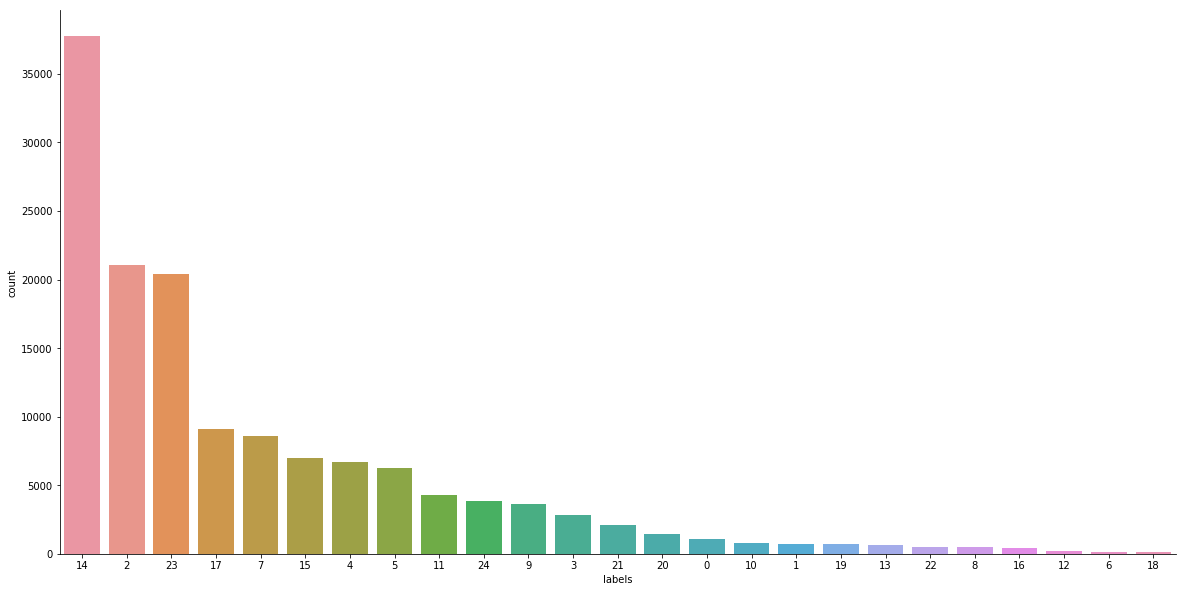

In [222]:
count_plot(col_name='labels', dataset=customers_scaled, fig_height=10, fig_width=20)

**Clusters Distribution in the General Dataset**

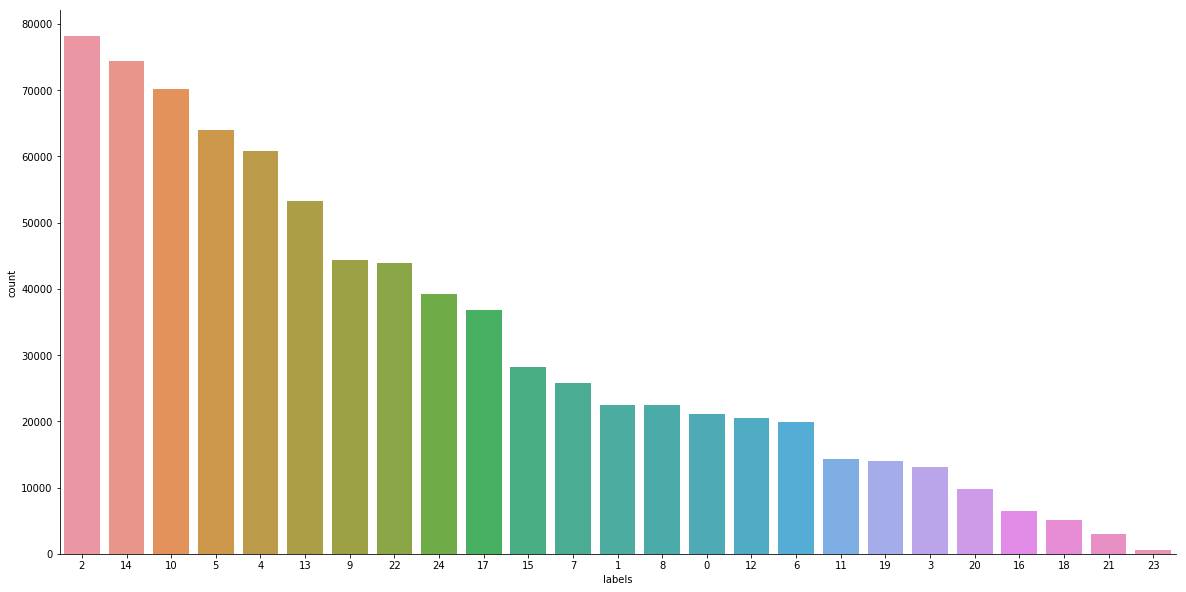

In [221]:
count_plot(col_name='labels', dataset=azdias_scaled, fig_height=10, fig_width=20)

*Cluster 23 in the customers dataset is over represented compared to the general population.*

*Cluster 13 in the customers dataset is under represented compared to the general population.* 

*The following features were critical based on the analysis done in section 2.3. These factors were the most critical factors in explaining positivily variance in dimension 1.*

- LP_STATUS_GROB_1.0 (Personal feature) is a person with a social status, income level, that is considered low. 
- HH_EINKOMMEN_SCORE which reflects the estimated household net income. 
- wealth which is a RR4 micro-cell feature has a similar weight to HH_EINKOMMEN_SCORE. 
- PLZ8_ANTG3 reflects the number of 6-10 family houses in the PLZ8 region and this is macro-cell

*let's see how these features are correlcated with the genral and customer dataset for cluster 23.*

In [341]:
# Generate a bar chart of four columns where observations have a specific label
def customers_vs_general(col_names, label):
    fig, ax = plt.subplots(nrows=4, ncols=2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)
    for i in range(4):
        sns.countplot(x=col_names[i], data=customers_clean[customers_clean['labels']==label][col_names], ax=ax[i,0])
        ax[i,0].set_title('Customers')
        sns.countplot(x=col_names[i], data=azdias_dummies[azdias_dummies['labels']==label][col_names], ax =ax[i,1])
        ax[i,1].set_title('General')

**Bar Chart for Cluster 23 in the Customer and General Dataset - Over Represented**

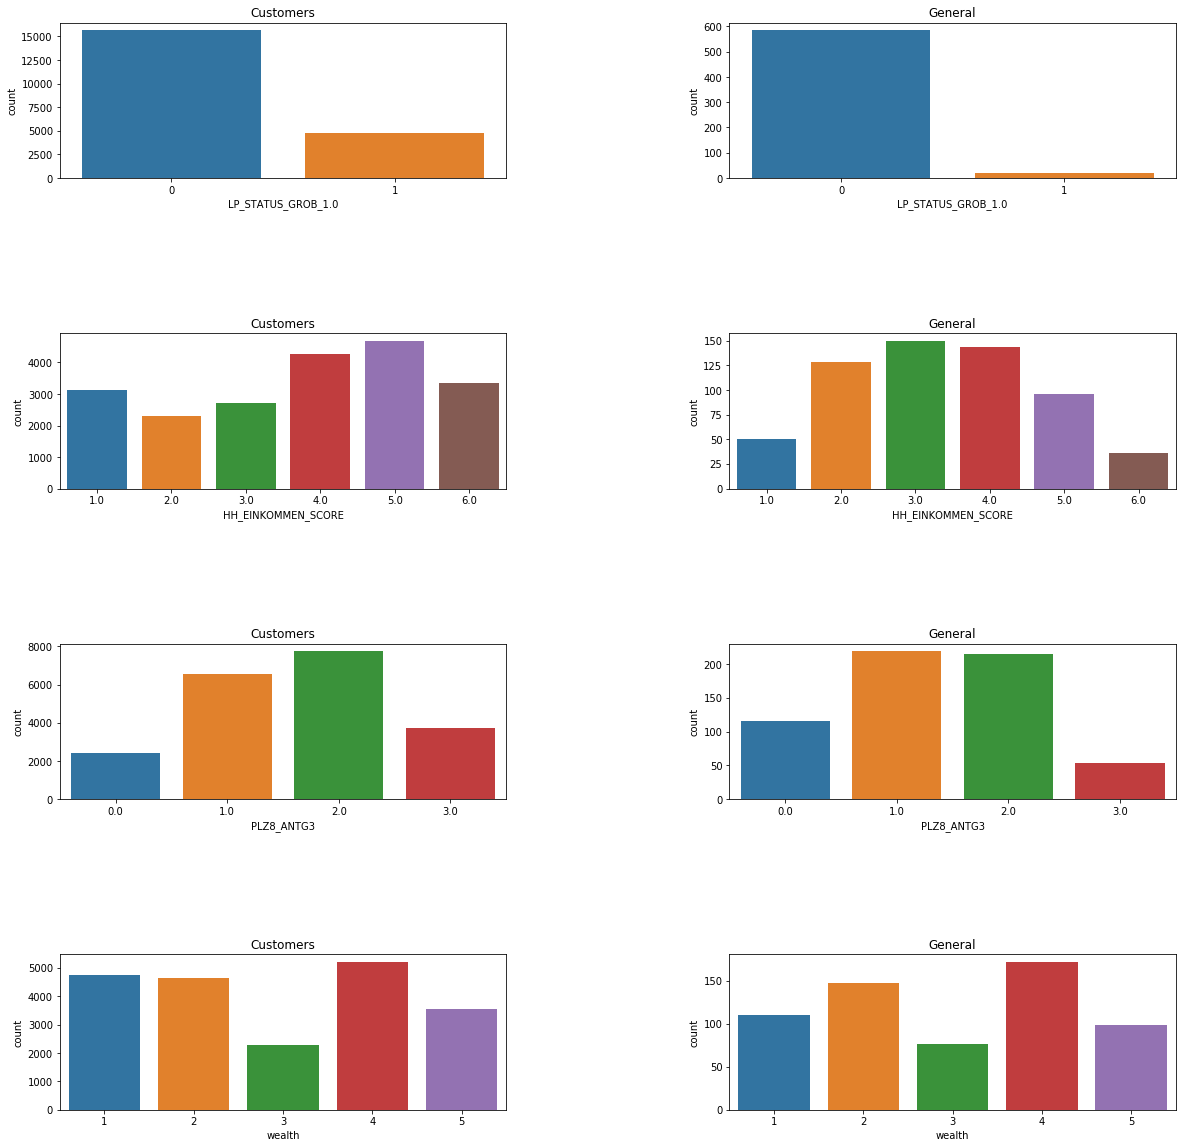

In [342]:
# shows the distribution of four columns where observations have a specific label
customers_vs_general(['LP_STATUS_GROB_1.0', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG3', 'wealth'], label=23);

*Looking at the above bar charts, It's clear that customers who are wealthy with high income are part of this cluster.*

**Bar Chart for Cluster 23 in the Customer and General Dataset - Under Represented**

*By looking at the comparision below, it's clear also that the difference between the two clusters is in the income, family size and wealth.  This also confirms the observation obtained from the over represented cluster.*

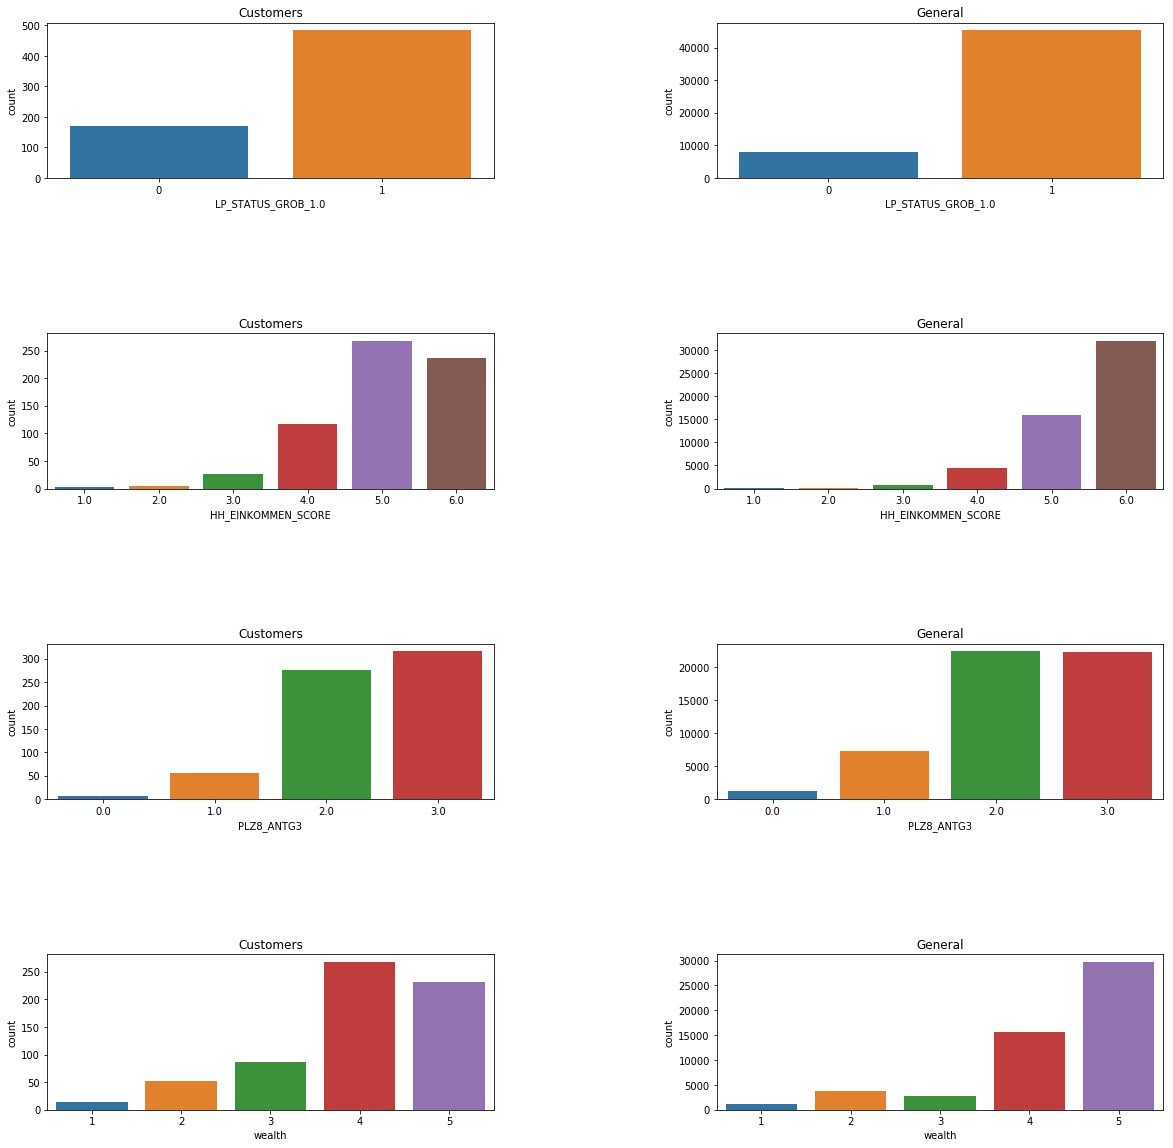

In [343]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

customers_vs_general(['LP_STATUS_GROB_1.0', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG3', 'wealth'], label=13);

### Discussion 3.3: Compare Customer Data to Demographics Data

*The following features were critical based on the analysis done in section 2.3. These factors were the most critical factors in explaining positivily variance in dimension 1.*

- LP_STATUS_GROB_1.0 (Personal feature) is a person with a social status, income level, that is considered low.
- HH_EINKOMMEN_SCORE which reflects the estimated household net income.
- wealth which is a RR4 micro-cell feature has a similar weight to HH_EINKOMMEN_SCORE.
- PLZ8_ANTG3 reflects the number of 6-10 family houses in the PLZ8 region and this is macro-cell

*cluster 23 was over-represented in the customer data and clsuter 13 was under represented.*

*When we performed the above analysis, it's clear that customers who are wealthy with high income are part of cluster 23. the opposite can be said on cluster 13*

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.